In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
import itertools
import random
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import torch.nn.utils.prune as prune
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import logging
from functools import partial
from collections import OrderedDict
import seaborn as sns
import matplotlib as mp
import time
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler



import importlib
import sys

sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from utils.models.VQ_VAE import Model
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

import json
from tqdm import tqdm


# instead, we plug in our OWN datasets

In [2]:
suggested_genes_file_1 = '../../data/PD_genes_of_interest/signif_de_Disease_status_IDIOPATHIC_PD_01.tsv'
suggested_genes_file_2 = '../../data/PD_genes_of_interest/signif_de_PD_DIAGNOSIS_0.1.tsv'

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  5 ...
min MAD 0.0
max MAD 4194.0


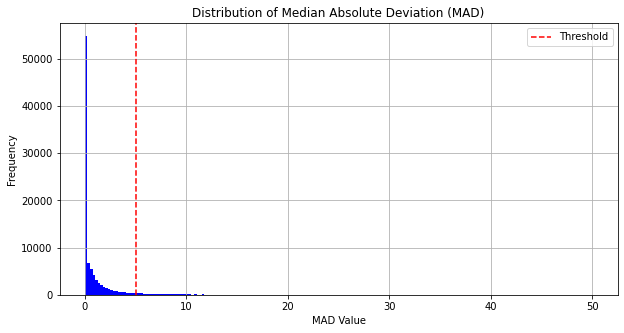

removing 89395 genes under the MAD threshold from the dataset
number of genes selected :  5914
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series
not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
retriving symbols for genes
selecting genes based on median absolute deviation threshold:  2 ...
min MAD 0.0
max MAD 4192.0999999999985


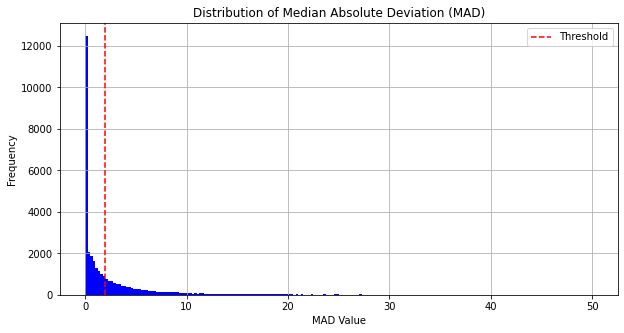

removing 22641 genes under the MAD threshold from the dataset
number of genes selected :  11928
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [3]:
# experiment 1
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 5, 
    gene_selection_file = None)

data_1 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_1 = data_1.shape[1]
data_num_1 = data_1.shape[0]
dat_1 = data_1.reshape(-1,1,feature_num_1)


x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    feature_selection_threshold = 2, 
    gene_selection_file = None)

data_2 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_2 = data_2.shape[1]
data_num_2 = data_2.shape[0]
dat_2 = data_2.reshape(-1,1,feature_num_2)


not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  0 ...
min MAD 0.0
max MAD 2225.368


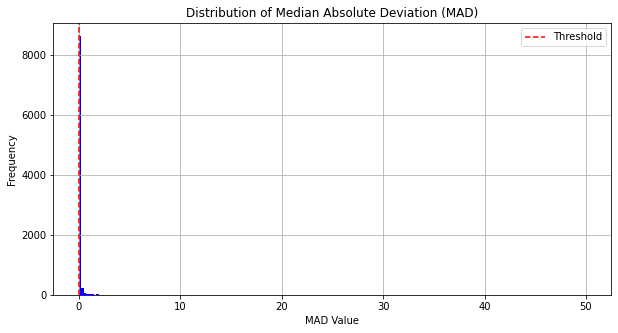

removing 6876 genes under the MAD threshold from the dataset
number of genes selected :  2185
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series
not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
number of genes selected: 2760
retriving symbols for genes
selecting genes based on median absolute deviation threshold:  0 ...
min MAD 0.0
max MAD 3562.5600000000013


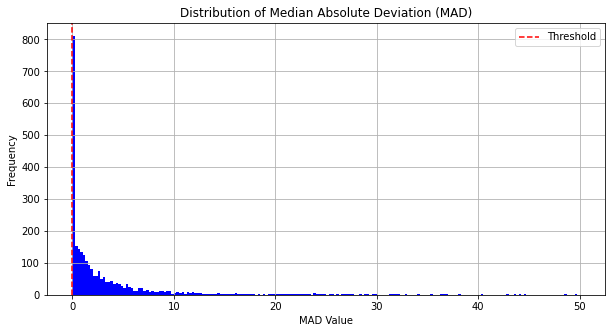

removing 618 genes under the MAD threshold from the dataset
number of genes selected :  2142
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [3]:
# experiment 2
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_1)

data_1 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_1 = data_1.shape[1]
data_num_1 = data_1.shape[0]
dat_1 = data_1.reshape(-1,1,feature_num_1)


x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_1)

data_2 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_2 = data_2.shape[1]
data_num_2 = data_2.shape[0]
dat_2 = data_2.reshape(-1,1,feature_num_2)


In [ ]:
# experiment 3
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_2)

data_1 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_1 = data_1.shape[1]
data_num_1 = data_1.shape[0]
dat_1 = data_1.reshape(-1,1,feature_num_1)


x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_2)

data_2 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_2 = data_2.shape[1]
data_num_2 = data_2.shape[0]
dat_2 = data_2.reshape(-1,1,feature_num_2)


## End of experiment choice

In [4]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data1, data2 ,transform = None):
        self.transform = transform
        self.data1 = data1
        self.data2 = data2
        self.datanum = len(data1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data1 = torch.tensor(self.data1[idx]).float()
        out_data2 = torch.tensor(self.data2[idx]).float()
        if self.transform:
            out_data1 = self.transform(out_data1)
            out_data2 = self.transform(out_data2)

        return out_data1,out_data2

In [5]:
train_1, test_1 = train_test_split(dat_1, test_size = 0.1,random_state = 66)
print('train_data_1:',len(train_1))
print('test_data_1:',len(test_1))

train_2, test_2 = train_test_split(dat_2, test_size = 0.1,random_state = 66)
print('train_data_2:',len(train_2))
print('test_data_2:',len(test_2))

train_data_set = Mydatasets(data1 = train_1, data2 = train_2)
test_data_set = Mydatasets(data1 = test_1, data2 = test_2)

train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 64, shuffle=False)

train_data_1: 4000
test_data_1: 445
train_data_2: 4000
test_data_2: 445


In [6]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = rearrange(inputs, 'b c l -> b l c')
        inputs = inputs.contiguous()
        #inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        quantized = rearrange(quantized, 'b c l -> b l c')
        quantized = quantized.contiguous()
        
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
        return loss, quantized, perplexity, encodings
    
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = rearrange(inputs, 'b c l -> b l c')
        inputs = inputs.contiguous()
        #inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        quantized = rearrange(quantized, 'b c l -> b l c')
        quantized = quantized.contiguous()
        
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
               
        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
        return loss, quantized, perplexity, encodings   

In [7]:
class ResidualStack(nn.Module):
    def __init__(self, encoder_dim):
        super(ResidualStack, self).__init__()
        
        self.block = nn.Sequential(
            nn.Linear(encoder_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, encoder_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return x + self.block(x)
    
class Encoder(nn.Module):
    def __init__(self, input_size_1, encoder_dim, dropout):
        super(Encoder, self).__init__()

        self.lay1 = nn.Sequential(
            nn.Linear(input_size_1, 2048),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.lay2 = nn.Sequential(
            nn.Linear(2048, encoder_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self._residual_stack = ResidualStack(encoder_dim)

    def forward(self, inputs_1):
        x_1 = self.lay1(inputs_1)
        x_1 = self.lay2(x_1)
        x_1 = self._residual_stack(x_1)
        return x_1

    def forward(self, inputs_2):
        x_1 = self.lay1(inputs_2)
        x_1 = self.lay2(x_1)
        x_1 = self._residual_stack(x_1)
        return x_1

class Decoder(nn.Module):
    def __init__(self, num_embeddings, input_size_1, encoder_dim, dropout):
        super(Decoder, self).__init__()
        
        self.lay0 = nn.Sequential(
            nn.Linear(num_embeddings, encoder_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        self._residual_stack = ResidualStack(encoder_dim)
        
        self.lay1 = nn.Sequential(
            nn.Linear(encoder_dim, 2048),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.lay2 = nn.Sequential(
            nn.Linear(2048, input_size_1),
            nn.GELU(),
            nn.Dropout(dropout)
        )

    def forward(self, inputs):
        x = self.lay0(inputs)
        x = self._residual_stack(x)
        x_1 = self.lay1(x)
        x_1 = self.lay2(x_1)
        return x_1

In [8]:
class Model(nn.Module):
    def __init__(self, num_classes, input_size_1, input_size_2, encoder_dim_b, encoder_dim_t, num_embeddings_b, num_embeddings_t, embedding_dim_b, embedding_dim_t, commitment_cost, dropout, decay=0):
        super(Model, self).__init__()
        
        self._encoder_b = Encoder(input_size_1, encoder_dim_b, dropout)
        self._encoder_b2 = Encoder(input_size_2, encoder_dim_b, dropout)
        self._encoder_t = Encoder(encoder_dim_b, encoder_dim_t, dropout)
        
        self._pre_vq_conv_b = nn.Linear(encoder_dim_b, num_embeddings_b)
        self._pre_vq_conv_t = nn.Linear(encoder_dim_t, num_embeddings_t)
        
        if decay > 0.0:
            self._vq_vae_b = VectorQuantizerEMA(num_embeddings_b, embedding_dim_b, commitment_cost, decay)
            self._vq_vae_t = VectorQuantizerEMA(num_embeddings_t, embedding_dim_t, commitment_cost, decay)
        else:
            self._vq_vae_b = VectorQuantizer(num_embeddings_b, embedding_dim_b, commitment_cost)
            self._vq_vae_t = VectorQuantizer(num_embeddings_t, embedding_dim_t, commitment_cost)
        
        self._upsample = nn.Linear(num_embeddings_t, num_embeddings_b)
        
        self._decoder_t = Decoder(num_embeddings_t, encoder_dim_b, encoder_dim_t, dropout)   
        self._decoder_b = Decoder(num_embeddings_b, input_size_1, encoder_dim_b, dropout)
        self._decoder_b2 = Decoder(num_embeddings_b, input_size_2, encoder_dim_b, dropout)
        

    def forward(self, x1, x2):
        #Top level
        z_b = self._encoder_b(x1)
        z_t = self._encoder_t(z_b)
        z_t = self._pre_vq_conv_t(z_t)
        vq_loss_t, quantized_t, perplexity_t, _ = self._vq_vae_t(z_t)
        recon_t = self._decoder_t(quantized_t)
        
        #Bottom level
        z_b2 = self._encoder_b2(x2)
        z_final = z_b + z_b2 + recon_t
        z_final = self._pre_vq_conv_b(z_final)
        vq_loss_b, quantized_b, perplexity_b, _ = self._vq_vae_b(z_final)
        recon_b = self._decoder_b(quantized_b + self._upsample(quantized_t))
        recon_b2 = self._decoder_b2(quantized_b + self._upsample(quantized_t))
        variance_z_b = torch.var(z_b)
        return vq_loss_b, vq_loss_t, recon_b, recon_b2, recon_t, z_b, z_final, quantized_b, perplexity_b, variance_z_b

## Preping labels

In [9]:
metadata_path = "../../METADATA_200123.xlsx"

meta_data = pd.read_excel(metadata_path, header = 1, usecols = range(1,10) )
patient_ids = [int(name.split(".")[1]) for name in filenames]

# Create a dictionary to map 'Patient Number' to 'Disease Status'
patient_disease_status = dict(zip(meta_data['Patient Number'], meta_data['Disease Status']))

label = [patient_disease_status.get(patient_id, None) for patient_id in patient_ids]
num_classes = len(pd.Series(label).unique())

In [10]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("mps")

VQ_VAE = Model(
            dropout = 0.0,
            num_classes = num_classes,
            input_size_1 = feature_num_1,
            input_size_2 = feature_num_2,
            encoder_dim_b = 64,
            encoder_dim_t = 32,
            num_embeddings_b = 64,
            num_embeddings_t = 32,
            embedding_dim_b = 64,
            embedding_dim_t = 32, 
            commitment_cost = 1
           ).to(DEVICE)

Classifier_loss = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(VQ_VAE.parameters(), lr=1e-4, amsgrad=False)
data_variance_1 = np.var(dat_1)
data_variance_2 = np.var(dat_2)

#VQ_VAE.load_state_dict(torch.load('VQ_2_disc'),strict=False)
print(DEVICE)

mps


we need a proper training function


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [1/300],Recon Error: 2.1624, Perplexity: 1.0259
Epoch [1/300],Recon Error: 1.6265, Perplexity: 1.0000
Epoch [1/300],Recon Error: 1.4760, Perplexity: 1.0000


  0%|          | 1/300 [00:02<13:59,  2.81s/it]

Epoch [2/300],Recon Error: 1.0021, Perplexity: 1.0000
Epoch [2/300],Recon Error: 0.9721, Perplexity: 1.0000


  1%|          | 2/300 [00:03<09:09,  1.85s/it]

Epoch [2/300],Recon Error: 0.7917, Perplexity: 1.0000
Epoch [3/300],Recon Error: 0.8982, Perplexity: 1.0000
Epoch [3/300],Recon Error: 0.7286, Perplexity: 1.0000


  1%|          | 3/300 [00:05<07:37,  1.54s/it]

Epoch [3/300],Recon Error: 0.7119, Perplexity: 1.0000
Epoch [4/300],Recon Error: 0.6134, Perplexity: 1.0000
Epoch [4/300],Recon Error: 0.7270, Perplexity: 3.0366


  1%|▏         | 4/300 [00:06<06:53,  1.40s/it]

Epoch [4/300],Recon Error: 0.5104, Perplexity: 1.6295
Epoch [5/300],Recon Error: 0.5484, Perplexity: 2.2980
Epoch [5/300],Recon Error: 0.6515, Perplexity: 1.9244


  2%|▏         | 5/300 [00:07<06:32,  1.33s/it]

Epoch [5/300],Recon Error: 0.7548, Perplexity: 2.1113
Epoch [6/300],Recon Error: 0.5984, Perplexity: 2.2217
Epoch [6/300],Recon Error: 0.6585, Perplexity: 2.6439


  2%|▏         | 6/300 [00:08<06:20,  1.30s/it]

Epoch [6/300],Recon Error: 0.5389, Perplexity: 2.3655
Epoch [7/300],Recon Error: 0.6023, Perplexity: 2.4193
Epoch [7/300],Recon Error: 0.5420, Perplexity: 2.3982


  2%|▏         | 7/300 [00:09<06:06,  1.25s/it]

Epoch [7/300],Recon Error: 0.5636, Perplexity: 2.5099
Epoch [8/300],Recon Error: 0.5633, Perplexity: 2.5852
Epoch [8/300],Recon Error: 0.5594, Perplexity: 2.6317


  3%|▎         | 8/300 [00:11<05:57,  1.22s/it]

Epoch [8/300],Recon Error: 0.6976, Perplexity: 2.4765
Epoch [9/300],Recon Error: 0.5065, Perplexity: 2.5372
Epoch [9/300],Recon Error: 0.7036, Perplexity: 2.7028


  3%|▎         | 9/300 [00:12<05:47,  1.19s/it]

Epoch [9/300],Recon Error: 0.6094, Perplexity: 2.6849
Epoch [10/300],Recon Error: 0.4988, Perplexity: 2.6479
Epoch [10/300],Recon Error: 0.6231, Perplexity: 2.6722


  3%|▎         | 10/300 [00:13<05:39,  1.17s/it]

Epoch [10/300],Recon Error: 0.5960, Perplexity: 2.6463
Epoch [11/300],Recon Error: 0.4859, Perplexity: 2.5991
Epoch [11/300],Recon Error: 0.5523, Perplexity: 2.4771


  4%|▎         | 11/300 [00:14<05:33,  1.15s/it]

Epoch [11/300],Recon Error: 0.5713, Perplexity: 2.5235
Epoch [12/300],Recon Error: 0.4984, Perplexity: 2.6109
Epoch [12/300],Recon Error: 0.5063, Perplexity: 2.2255


  4%|▍         | 12/300 [00:15<05:28,  1.14s/it]

Epoch [12/300],Recon Error: 0.4934, Perplexity: 2.4970
Epoch [13/300],Recon Error: 0.5248, Perplexity: 2.2148
Epoch [13/300],Recon Error: 0.5376, Perplexity: 2.4892


  4%|▍         | 13/300 [00:16<05:28,  1.15s/it]

Epoch [13/300],Recon Error: 0.5868, Perplexity: 2.4394
Epoch [14/300],Recon Error: 0.4337, Perplexity: 2.0783
Epoch [14/300],Recon Error: 0.5406, Perplexity: 1.9169


  5%|▍         | 14/300 [00:17<05:24,  1.14s/it]

Epoch [14/300],Recon Error: 0.4517, Perplexity: 1.8569
Epoch [15/300],Recon Error: 0.4759, Perplexity: 2.0970
Epoch [15/300],Recon Error: 0.4767, Perplexity: 1.8962


  5%|▌         | 15/300 [00:18<05:21,  1.13s/it]

Epoch [15/300],Recon Error: 0.8718, Perplexity: 2.1245
Epoch [16/300],Recon Error: 0.9479, Perplexity: 1.6803
Epoch [16/300],Recon Error: 0.9443, Perplexity: 1.7483


  5%|▌         | 16/300 [00:20<05:19,  1.12s/it]

Epoch [16/300],Recon Error: 0.9317, Perplexity: 1.7951
Epoch [17/300],Recon Error: 1.0061, Perplexity: 1.9630
Epoch [17/300],Recon Error: 1.1267, Perplexity: 2.0119


  6%|▌         | 17/300 [00:21<05:19,  1.13s/it]

Epoch [17/300],Recon Error: 1.0015, Perplexity: 1.7022
Epoch [18/300],Recon Error: 1.1015, Perplexity: 1.6058
Epoch [18/300],Recon Error: 1.1766, Perplexity: 1.8761


  6%|▌         | 18/300 [00:22<05:17,  1.12s/it]

Epoch [18/300],Recon Error: 1.0263, Perplexity: 2.4368
Epoch [19/300],Recon Error: 1.0175, Perplexity: 2.0113
Epoch [19/300],Recon Error: 0.9821, Perplexity: 1.7508


  6%|▋         | 19/300 [00:23<05:15,  1.12s/it]

Epoch [19/300],Recon Error: 1.0141, Perplexity: 2.0845
Epoch [20/300],Recon Error: 1.0342, Perplexity: 2.2830
Epoch [20/300],Recon Error: 0.8966, Perplexity: 2.1242


  7%|▋         | 20/300 [00:24<05:14,  1.12s/it]

Epoch [20/300],Recon Error: 0.8511, Perplexity: 1.8259
Epoch [21/300],Recon Error: 0.8946, Perplexity: 1.8707
Epoch [21/300],Recon Error: 0.7978, Perplexity: 1.8093


  7%|▋         | 21/300 [00:25<05:14,  1.13s/it]

Epoch [21/300],Recon Error: 0.9073, Perplexity: 2.1816
Epoch [22/300],Recon Error: 0.7964, Perplexity: 2.5007
Epoch [22/300],Recon Error: 0.9140, Perplexity: 2.5781


  7%|▋         | 22/300 [00:26<05:13,  1.13s/it]

Epoch [22/300],Recon Error: 0.5762, Perplexity: 1.7767
Epoch [23/300],Recon Error: 0.7488, Perplexity: 2.3044
Epoch [23/300],Recon Error: 0.6138, Perplexity: 1.7436


  8%|▊         | 23/300 [00:27<05:10,  1.12s/it]

Epoch [23/300],Recon Error: 0.6732, Perplexity: 2.1615
Epoch [24/300],Recon Error: 0.6621, Perplexity: 2.4067
Epoch [24/300],Recon Error: 0.7257, Perplexity: 2.3976


  8%|▊         | 24/300 [00:29<05:08,  1.12s/it]

Epoch [24/300],Recon Error: 0.5974, Perplexity: 2.3859
Epoch [25/300],Recon Error: 0.6841, Perplexity: 2.1206
Epoch [25/300],Recon Error: 0.6812, Perplexity: 2.2030


  8%|▊         | 25/300 [00:30<05:07,  1.12s/it]

Epoch [25/300],Recon Error: 0.6293, Perplexity: 1.9443
Epoch [26/300],Recon Error: 0.4811, Perplexity: 2.0891
Epoch [26/300],Recon Error: 0.5344, Perplexity: 2.1599


  9%|▊         | 26/300 [00:31<05:07,  1.12s/it]

Epoch [26/300],Recon Error: 0.5790, Perplexity: 2.4889
Epoch [27/300],Recon Error: 0.5233, Perplexity: 2.2342
Epoch [27/300],Recon Error: 0.5162, Perplexity: 2.5064


  9%|▉         | 27/300 [00:32<05:05,  1.12s/it]

Epoch [27/300],Recon Error: 0.3807, Perplexity: 2.3657
Epoch [28/300],Recon Error: 0.4505, Perplexity: 2.5361
Epoch [28/300],Recon Error: 0.5806, Perplexity: 1.9290


  9%|▉         | 28/300 [00:33<05:04,  1.12s/it]

Epoch [28/300],Recon Error: 0.4971, Perplexity: 2.7645
Epoch [29/300],Recon Error: 0.5422, Perplexity: 2.3622
Epoch [29/300],Recon Error: 0.4209, Perplexity: 2.6456


 10%|▉         | 29/300 [00:34<05:05,  1.13s/it]

Epoch [29/300],Recon Error: 0.4887, Perplexity: 2.7927
Epoch [30/300],Recon Error: 0.3841, Perplexity: 2.6484
Epoch [30/300],Recon Error: 0.4044, Perplexity: 2.7043


 10%|█         | 30/300 [00:35<05:04,  1.13s/it]

Epoch [30/300],Recon Error: 0.5510, Perplexity: 2.2581
Epoch [31/300],Recon Error: 0.5834, Perplexity: 1.1464
Epoch [31/300],Recon Error: 0.6932, Perplexity: 1.8207


 10%|█         | 31/300 [00:36<05:04,  1.13s/it]

Epoch [31/300],Recon Error: 1.6115, Perplexity: 1.7665
Epoch [32/300],Recon Error: 1.7122, Perplexity: 1.3864
Epoch [32/300],Recon Error: 0.9275, Perplexity: 1.4945


 11%|█         | 32/300 [00:38<05:02,  1.13s/it]

Epoch [32/300],Recon Error: 0.8949, Perplexity: 1.9389
Epoch [33/300],Recon Error: 0.5428, Perplexity: 1.7085
Epoch [33/300],Recon Error: 0.5198, Perplexity: 3.3088


 11%|█         | 33/300 [00:39<05:00,  1.13s/it]

Epoch [33/300],Recon Error: 0.4772, Perplexity: 3.0073
Epoch [34/300],Recon Error: 0.7933, Perplexity: 1.4097
Epoch [34/300],Recon Error: 0.7119, Perplexity: 1.0956


 11%|█▏        | 34/300 [00:40<04:58,  1.12s/it]

Epoch [34/300],Recon Error: 0.6754, Perplexity: 1.0838
Epoch [35/300],Recon Error: 0.8031, Perplexity: 1.4600
Epoch [35/300],Recon Error: 0.8505, Perplexity: 2.4503


 12%|█▏        | 35/300 [00:41<04:59,  1.13s/it]

Epoch [35/300],Recon Error: 1.0988, Perplexity: 1.6909
Epoch [36/300],Recon Error: 1.1644, Perplexity: 2.6745
Epoch [36/300],Recon Error: 1.2686, Perplexity: 1.9512


 12%|█▏        | 36/300 [00:42<04:57,  1.13s/it]

Epoch [36/300],Recon Error: 1.2152, Perplexity: 1.5709
Epoch [37/300],Recon Error: 1.0799, Perplexity: 2.3639
Epoch [37/300],Recon Error: 0.7395, Perplexity: 2.6079


 12%|█▏        | 37/300 [00:43<04:58,  1.13s/it]

Epoch [37/300],Recon Error: 0.9589, Perplexity: 2.7393
Epoch [38/300],Recon Error: 0.7192, Perplexity: 2.7073
Epoch [38/300],Recon Error: 0.7147, Perplexity: 2.6562


 13%|█▎        | 38/300 [00:44<04:58,  1.14s/it]

Epoch [38/300],Recon Error: 0.7771, Perplexity: 2.8062
Epoch [39/300],Recon Error: 0.8403, Perplexity: 2.7771
Epoch [39/300],Recon Error: 0.7382, Perplexity: 2.6752


 13%|█▎        | 39/300 [00:46<04:58,  1.14s/it]

Epoch [39/300],Recon Error: 0.7490, Perplexity: 3.0288
Epoch [40/300],Recon Error: 0.6431, Perplexity: 2.7740
Epoch [40/300],Recon Error: 0.6200, Perplexity: 2.7388


 13%|█▎        | 40/300 [00:47<04:56,  1.14s/it]

Epoch [40/300],Recon Error: 0.6880, Perplexity: 3.0640
Epoch [41/300],Recon Error: 0.5795, Perplexity: 2.9623
Epoch [41/300],Recon Error: 0.5570, Perplexity: 2.8197


 14%|█▎        | 41/300 [00:48<04:54,  1.14s/it]

Epoch [41/300],Recon Error: 0.6198, Perplexity: 3.0342
Epoch [42/300],Recon Error: 0.4333, Perplexity: 2.8014
Epoch [42/300],Recon Error: 0.3937, Perplexity: 3.0428


 14%|█▍        | 42/300 [00:49<04:53,  1.14s/it]

Epoch [42/300],Recon Error: 0.4468, Perplexity: 2.8985
Epoch [43/300],Recon Error: 0.4008, Perplexity: 2.8101
Epoch [43/300],Recon Error: 0.3869, Perplexity: 3.1123


 14%|█▍        | 43/300 [00:50<04:53,  1.14s/it]

Epoch [43/300],Recon Error: 0.4829, Perplexity: 2.9066
Epoch [44/300],Recon Error: 0.4192, Perplexity: 2.9127
Epoch [44/300],Recon Error: 0.4978, Perplexity: 3.0446


 15%|█▍        | 44/300 [00:51<05:00,  1.17s/it]

Epoch [44/300],Recon Error: 0.3808, Perplexity: 2.8654
Epoch [45/300],Recon Error: 0.3275, Perplexity: 3.0055
Epoch [45/300],Recon Error: 0.3987, Perplexity: 2.9599


 15%|█▌        | 45/300 [00:52<04:58,  1.17s/it]

Epoch [45/300],Recon Error: 0.4020, Perplexity: 3.1737
Epoch [46/300],Recon Error: 0.4174, Perplexity: 3.0378
Epoch [46/300],Recon Error: 0.4102, Perplexity: 3.1621


 15%|█▌        | 46/300 [00:54<04:59,  1.18s/it]

Epoch [46/300],Recon Error: 0.3138, Perplexity: 2.7858
Epoch [47/300],Recon Error: 0.4531, Perplexity: 3.1244
Epoch [47/300],Recon Error: 0.3046, Perplexity: 2.8504


 16%|█▌        | 47/300 [00:55<04:58,  1.18s/it]

Epoch [47/300],Recon Error: 0.3336, Perplexity: 2.8748
Epoch [48/300],Recon Error: 0.3476, Perplexity: 2.8199
Epoch [48/300],Recon Error: 0.4880, Perplexity: 2.9386


 16%|█▌        | 48/300 [00:56<05:00,  1.19s/it]

Epoch [48/300],Recon Error: 0.4914, Perplexity: 3.0682
Epoch [49/300],Recon Error: 0.3582, Perplexity: 2.8925
Epoch [49/300],Recon Error: 0.2893, Perplexity: 2.6725


 16%|█▋        | 49/300 [00:57<04:58,  1.19s/it]

Epoch [49/300],Recon Error: 0.3920, Perplexity: 2.9391
Epoch [50/300],Recon Error: 0.3563, Perplexity: 2.8150
Epoch [50/300],Recon Error: 0.3960, Perplexity: 2.8139


 17%|█▋        | 50/300 [00:58<04:55,  1.18s/it]

Epoch [50/300],Recon Error: 0.4696, Perplexity: 2.8005
Epoch [51/300],Recon Error: 0.3768, Perplexity: 2.8289
Epoch [51/300],Recon Error: 0.3955, Perplexity: 2.8519


 17%|█▋        | 51/300 [01:00<04:53,  1.18s/it]

Epoch [51/300],Recon Error: 0.3850, Perplexity: 2.9000
Epoch [52/300],Recon Error: 0.4591, Perplexity: 2.8925
Epoch [52/300],Recon Error: 0.4574, Perplexity: 2.9209


 17%|█▋        | 52/300 [01:01<04:57,  1.20s/it]

Epoch [52/300],Recon Error: 0.5017, Perplexity: 2.8316
Epoch [53/300],Recon Error: 0.5057, Perplexity: 2.8261
Epoch [53/300],Recon Error: 0.4308, Perplexity: 2.7515


 18%|█▊        | 53/300 [01:02<04:54,  1.19s/it]

Epoch [53/300],Recon Error: 0.3732, Perplexity: 2.9944
Epoch [54/300],Recon Error: 0.5204, Perplexity: 3.1032
Epoch [54/300],Recon Error: 0.4317, Perplexity: 2.9349


 18%|█▊        | 54/300 [01:03<04:53,  1.19s/it]

Epoch [54/300],Recon Error: 0.3893, Perplexity: 2.7693
Epoch [55/300],Recon Error: 0.4776, Perplexity: 2.9906
Epoch [55/300],Recon Error: 0.4204, Perplexity: 3.1951


 18%|█▊        | 55/300 [01:04<04:51,  1.19s/it]

Epoch [55/300],Recon Error: 0.4273, Perplexity: 2.9777
Epoch [56/300],Recon Error: 0.4980, Perplexity: 2.8546
Epoch [56/300],Recon Error: 0.3648, Perplexity: 2.9252


 19%|█▊        | 56/300 [01:06<04:52,  1.20s/it]

Epoch [56/300],Recon Error: 0.3993, Perplexity: 2.9282
Epoch [57/300],Recon Error: 0.4790, Perplexity: 2.7218
Epoch [57/300],Recon Error: 0.5183, Perplexity: 2.3516


 19%|█▉        | 57/300 [01:07<04:50,  1.19s/it]

Epoch [57/300],Recon Error: 0.5302, Perplexity: 2.5793
Epoch [58/300],Recon Error: 0.4868, Perplexity: 3.3828
Epoch [58/300],Recon Error: 0.4309, Perplexity: 3.0683


 19%|█▉        | 58/300 [01:08<04:48,  1.19s/it]

Epoch [58/300],Recon Error: 0.4636, Perplexity: 2.1011
Epoch [59/300],Recon Error: 0.5906, Perplexity: 2.6891
Epoch [59/300],Recon Error: 0.6029, Perplexity: 1.8995


 20%|█▉        | 59/300 [01:09<04:46,  1.19s/it]

Epoch [59/300],Recon Error: 0.7108, Perplexity: 2.8779
Epoch [60/300],Recon Error: 0.6009, Perplexity: 2.9234
Epoch [60/300],Recon Error: 0.6270, Perplexity: 2.5546


 20%|██        | 60/300 [01:10<04:47,  1.20s/it]

Epoch [60/300],Recon Error: 0.6775, Perplexity: 2.4594
Epoch [61/300],Recon Error: 1.6428, Perplexity: 1.6019
Epoch [61/300],Recon Error: 1.3919, Perplexity: 1.3027


 20%|██        | 61/300 [01:12<04:48,  1.21s/it]

Epoch [61/300],Recon Error: 1.0677, Perplexity: 1.2185
Epoch [62/300],Recon Error: 0.9009, Perplexity: 1.4829
Epoch [62/300],Recon Error: 0.7220, Perplexity: 1.2614


 21%|██        | 62/300 [01:13<04:46,  1.20s/it]

Epoch [62/300],Recon Error: 0.8383, Perplexity: 1.8191
Epoch [63/300],Recon Error: 0.7803, Perplexity: 2.4077
Epoch [63/300],Recon Error: 0.7420, Perplexity: 3.2507


 21%|██        | 63/300 [01:14<04:44,  1.20s/it]

Epoch [63/300],Recon Error: 0.5983, Perplexity: 2.9323
Epoch [64/300],Recon Error: 0.6862, Perplexity: 1.8148
Epoch [64/300],Recon Error: 0.6504, Perplexity: 1.4037


 21%|██▏       | 64/300 [01:15<04:43,  1.20s/it]

Epoch [64/300],Recon Error: 0.5908, Perplexity: 1.3622
Epoch [65/300],Recon Error: 0.6141, Perplexity: 2.1541
Epoch [65/300],Recon Error: 0.6028, Perplexity: 1.9997


 22%|██▏       | 65/300 [01:16<04:43,  1.21s/it]

Epoch [65/300],Recon Error: 0.5957, Perplexity: 1.9437
Epoch [66/300],Recon Error: 0.5315, Perplexity: 2.1321
Epoch [66/300],Recon Error: 0.4666, Perplexity: 2.1110


 22%|██▏       | 66/300 [01:18<04:43,  1.21s/it]

Epoch [66/300],Recon Error: 0.5097, Perplexity: 2.3022
Epoch [67/300],Recon Error: 0.5008, Perplexity: 2.1237
Epoch [67/300],Recon Error: 0.4209, Perplexity: 2.1201


 22%|██▏       | 67/300 [01:19<05:03,  1.30s/it]

Epoch [67/300],Recon Error: 0.5483, Perplexity: 2.2793
Epoch [68/300],Recon Error: 0.5689, Perplexity: 2.4945
Epoch [68/300],Recon Error: 0.4833, Perplexity: 2.4581


 23%|██▎       | 68/300 [01:20<04:54,  1.27s/it]

Epoch [68/300],Recon Error: 0.4735, Perplexity: 2.5296
Epoch [69/300],Recon Error: 0.4333, Perplexity: 2.5719
Epoch [69/300],Recon Error: 0.4832, Perplexity: 2.5923


 23%|██▎       | 69/300 [01:22<05:34,  1.45s/it]

Epoch [69/300],Recon Error: 0.4430, Perplexity: 2.5026
Epoch [70/300],Recon Error: 0.4206, Perplexity: 2.6536
Epoch [70/300],Recon Error: 0.4654, Perplexity: 2.6786


 23%|██▎       | 70/300 [01:24<05:31,  1.44s/it]

Epoch [70/300],Recon Error: 0.4540, Perplexity: 2.5151
Epoch [71/300],Recon Error: 0.4289, Perplexity: 2.6804
Epoch [71/300],Recon Error: 0.4439, Perplexity: 2.7388


 24%|██▎       | 71/300 [01:25<05:44,  1.51s/it]

Epoch [71/300],Recon Error: 0.4129, Perplexity: 2.6042
Epoch [72/300],Recon Error: 0.4280, Perplexity: 2.6671
Epoch [72/300],Recon Error: 0.3811, Perplexity: 2.6484


 24%|██▍       | 72/300 [01:27<05:46,  1.52s/it]

Epoch [72/300],Recon Error: 0.4282, Perplexity: 2.7457
Epoch [73/300],Recon Error: 0.3989, Perplexity: 2.9102
Epoch [73/300],Recon Error: 0.4365, Perplexity: 3.0166


 24%|██▍       | 73/300 [01:28<05:26,  1.44s/it]

Epoch [73/300],Recon Error: 0.4370, Perplexity: 3.1314
Epoch [74/300],Recon Error: 0.4144, Perplexity: 2.8567
Epoch [74/300],Recon Error: 0.4649, Perplexity: 3.3846


 25%|██▍       | 74/300 [01:30<05:34,  1.48s/it]

Epoch [74/300],Recon Error: 0.4392, Perplexity: 3.0662
Epoch [75/300],Recon Error: 0.4358, Perplexity: 3.1640
Epoch [75/300],Recon Error: 0.5075, Perplexity: 3.3299


 25%|██▌       | 75/300 [01:31<05:22,  1.43s/it]

Epoch [75/300],Recon Error: 0.3795, Perplexity: 2.7716
Epoch [76/300],Recon Error: 0.4042, Perplexity: 2.6702
Epoch [76/300],Recon Error: 0.4072, Perplexity: 2.6003


 25%|██▌       | 76/300 [01:32<05:06,  1.37s/it]

Epoch [76/300],Recon Error: 0.3683, Perplexity: 2.8148
Epoch [77/300],Recon Error: 0.3718, Perplexity: 2.7402
Epoch [77/300],Recon Error: 0.3772, Perplexity: 2.8733


 26%|██▌       | 77/300 [01:33<04:54,  1.32s/it]

Epoch [77/300],Recon Error: 0.3841, Perplexity: 2.8870
Epoch [78/300],Recon Error: 0.3942, Perplexity: 3.0046
Epoch [78/300],Recon Error: 0.3325, Perplexity: 2.9492


 26%|██▌       | 78/300 [01:35<04:46,  1.29s/it]

Epoch [78/300],Recon Error: 0.3504, Perplexity: 3.0598
Epoch [79/300],Recon Error: 0.3609, Perplexity: 3.1187
Epoch [79/300],Recon Error: 0.3793, Perplexity: 2.8910


 26%|██▋       | 79/300 [01:36<04:43,  1.28s/it]

Epoch [79/300],Recon Error: 0.4031, Perplexity: 2.9733
Epoch [80/300],Recon Error: 0.4200, Perplexity: 3.0493
Epoch [80/300],Recon Error: 0.4171, Perplexity: 2.8648


 27%|██▋       | 80/300 [01:37<04:38,  1.26s/it]

Epoch [80/300],Recon Error: 0.4047, Perplexity: 2.8012
Epoch [81/300],Recon Error: 0.3220, Perplexity: 2.6152
Epoch [81/300],Recon Error: 0.3311, Perplexity: 2.6730


 27%|██▋       | 81/300 [01:38<04:33,  1.25s/it]

Epoch [81/300],Recon Error: 0.3602, Perplexity: 2.7716
Epoch [82/300],Recon Error: 0.3047, Perplexity: 2.5454
Epoch [82/300],Recon Error: 0.3693, Perplexity: 2.8448


 27%|██▋       | 82/300 [01:40<04:33,  1.25s/it]

Epoch [82/300],Recon Error: 0.3710, Perplexity: 2.7999
Epoch [83/300],Recon Error: 0.4017, Perplexity: 2.9114
Epoch [83/300],Recon Error: 0.3566, Perplexity: 2.6427


 28%|██▊       | 83/300 [01:41<04:32,  1.25s/it]

Epoch [83/300],Recon Error: 0.4192, Perplexity: 2.6524
Epoch [84/300],Recon Error: 0.4045, Perplexity: 2.5883
Epoch [84/300],Recon Error: 0.4279, Perplexity: 2.6475


 28%|██▊       | 84/300 [01:42<04:30,  1.25s/it]

Epoch [84/300],Recon Error: 0.5576, Perplexity: 2.6277
Epoch [85/300],Recon Error: 0.6927, Perplexity: 2.0647
Epoch [85/300],Recon Error: 0.5685, Perplexity: 2.5689


 28%|██▊       | 85/300 [01:43<04:27,  1.24s/it]

Epoch [85/300],Recon Error: 0.6204, Perplexity: 2.0228
Epoch [86/300],Recon Error: 0.6335, Perplexity: 2.2465
Epoch [86/300],Recon Error: 0.6498, Perplexity: 2.4971


 29%|██▊       | 86/300 [01:45<04:25,  1.24s/it]

Epoch [86/300],Recon Error: 0.6648, Perplexity: 2.5103
Epoch [87/300],Recon Error: 0.6080, Perplexity: 2.4592
Epoch [87/300],Recon Error: 0.5936, Perplexity: 2.5715


 29%|██▉       | 87/300 [01:46<04:25,  1.25s/it]

Epoch [87/300],Recon Error: 0.5569, Perplexity: 2.5426
Epoch [88/300],Recon Error: 0.5500, Perplexity: 2.5654
Epoch [88/300],Recon Error: 0.5653, Perplexity: 2.7437


 29%|██▉       | 88/300 [01:47<04:22,  1.24s/it]

Epoch [88/300],Recon Error: 0.5079, Perplexity: 2.6762
Epoch [89/300],Recon Error: 0.5246, Perplexity: 2.7641
Epoch [89/300],Recon Error: 0.4974, Perplexity: 2.7740


 30%|██▉       | 89/300 [01:48<04:22,  1.24s/it]

Epoch [89/300],Recon Error: 0.4232, Perplexity: 2.4490
Epoch [90/300],Recon Error: 0.4477, Perplexity: 2.6785
Epoch [90/300],Recon Error: 0.4333, Perplexity: 2.7515


 30%|███       | 90/300 [01:50<04:21,  1.24s/it]

Epoch [90/300],Recon Error: 0.3905, Perplexity: 2.6318
Epoch [91/300],Recon Error: 0.4121, Perplexity: 2.9067
Epoch [91/300],Recon Error: 0.4069, Perplexity: 3.0556


 30%|███       | 91/300 [01:51<04:29,  1.29s/it]

Epoch [91/300],Recon Error: 0.3865, Perplexity: 3.0081
Epoch [92/300],Recon Error: 0.4726, Perplexity: 3.2594
Epoch [92/300],Recon Error: 0.4750, Perplexity: 2.9874


 31%|███       | 92/300 [01:52<04:24,  1.27s/it]

Epoch [92/300],Recon Error: 0.5131, Perplexity: 3.0586
Epoch [93/300],Recon Error: 0.4824, Perplexity: 2.9968
Epoch [93/300],Recon Error: 0.4760, Perplexity: 2.7258


 31%|███       | 93/300 [01:53<04:20,  1.26s/it]

Epoch [93/300],Recon Error: 0.6002, Perplexity: 3.0335
Epoch [94/300],Recon Error: 0.5918, Perplexity: 2.4464
Epoch [94/300],Recon Error: 0.5092, Perplexity: 2.2335


 31%|███▏      | 94/300 [01:55<04:15,  1.24s/it]

Epoch [94/300],Recon Error: 0.4137, Perplexity: 2.3785
Epoch [95/300],Recon Error: 0.4860, Perplexity: 2.3239
Epoch [95/300],Recon Error: 0.4661, Perplexity: 2.4381


 32%|███▏      | 95/300 [01:56<04:14,  1.24s/it]

Epoch [95/300],Recon Error: 0.3779, Perplexity: 2.5155
Epoch [96/300],Recon Error: 0.3627, Perplexity: 2.5927
Epoch [96/300],Recon Error: 0.3305, Perplexity: 2.6768


 32%|███▏      | 96/300 [01:57<04:28,  1.31s/it]

Epoch [96/300],Recon Error: 0.3214, Perplexity: 2.7502
Epoch [97/300],Recon Error: 0.3271, Perplexity: 2.8361
Epoch [97/300],Recon Error: 0.3163, Perplexity: 2.8490


 32%|███▏      | 97/300 [01:59<04:26,  1.31s/it]

Epoch [97/300],Recon Error: 0.3710, Perplexity: 3.0880
Epoch [98/300],Recon Error: 0.3611, Perplexity: 2.7223
Epoch [98/300],Recon Error: 0.3599, Perplexity: 2.8022


 33%|███▎      | 98/300 [02:00<04:21,  1.30s/it]

Epoch [98/300],Recon Error: 0.3292, Perplexity: 2.8229
Epoch [99/300],Recon Error: 0.3181, Perplexity: 2.5148
Epoch [99/300],Recon Error: 0.3366, Perplexity: 2.4575


 33%|███▎      | 99/300 [02:01<04:27,  1.33s/it]

Epoch [99/300],Recon Error: 0.3633, Perplexity: 2.5451
Epoch [100/300],Recon Error: 0.4293, Perplexity: 2.7734
Epoch [100/300],Recon Error: 0.3885, Perplexity: 2.6388


 33%|███▎      | 100/300 [02:03<04:27,  1.34s/it]

Epoch [100/300],Recon Error: 0.3985, Perplexity: 2.8008
Epoch [101/300],Recon Error: 0.3325, Perplexity: 2.6185
Epoch [101/300],Recon Error: 0.3328, Perplexity: 2.5878


 34%|███▎      | 101/300 [02:04<04:22,  1.32s/it]

Epoch [101/300],Recon Error: 0.3265, Perplexity: 2.6577
Epoch [102/300],Recon Error: 0.3684, Perplexity: 2.8881
Epoch [102/300],Recon Error: 0.3722, Perplexity: 2.9569


 34%|███▍      | 102/300 [02:05<04:18,  1.31s/it]

Epoch [102/300],Recon Error: 0.3532, Perplexity: 3.0929
Epoch [103/300],Recon Error: 0.2832, Perplexity: 2.8032
Epoch [103/300],Recon Error: 0.2803, Perplexity: 2.7224


 34%|███▍      | 103/300 [02:07<04:19,  1.32s/it]

Epoch [103/300],Recon Error: 0.3701, Perplexity: 3.3171
Epoch [104/300],Recon Error: 0.3905, Perplexity: 2.9433
Epoch [104/300],Recon Error: 0.4085, Perplexity: 2.9870


 35%|███▍      | 104/300 [02:08<04:18,  1.32s/it]

Epoch [104/300],Recon Error: 0.4025, Perplexity: 2.6788
Epoch [105/300],Recon Error: 0.3370, Perplexity: 2.7574
Epoch [105/300],Recon Error: 0.3108, Perplexity: 2.6244


 35%|███▌      | 105/300 [02:09<04:12,  1.30s/it]

Epoch [105/300],Recon Error: 0.3349, Perplexity: 2.8632
Epoch [106/300],Recon Error: 0.2934, Perplexity: 2.5240
Epoch [106/300],Recon Error: 0.3307, Perplexity: 2.7011


 35%|███▌      | 106/300 [02:10<04:09,  1.29s/it]

Epoch [106/300],Recon Error: 0.3178, Perplexity: 2.9523
Epoch [107/300],Recon Error: 0.3013, Perplexity: 2.8859
Epoch [107/300],Recon Error: 0.3072, Perplexity: 3.0705


 36%|███▌      | 107/300 [02:12<04:10,  1.30s/it]

Epoch [107/300],Recon Error: 0.3269, Perplexity: 3.0679
Epoch [108/300],Recon Error: 0.3476, Perplexity: 3.3425
Epoch [108/300],Recon Error: 0.3189, Perplexity: 3.2807


 36%|███▌      | 108/300 [02:13<04:06,  1.28s/it]

Epoch [108/300],Recon Error: 0.3145, Perplexity: 2.9870
Epoch [109/300],Recon Error: 0.3455, Perplexity: 2.9138
Epoch [109/300],Recon Error: 0.4093, Perplexity: 3.0200


 36%|███▋      | 109/300 [02:14<04:02,  1.27s/it]

Epoch [109/300],Recon Error: 0.3727, Perplexity: 2.8943
Epoch [110/300],Recon Error: 0.3211, Perplexity: 2.9500
Epoch [110/300],Recon Error: 0.3200, Perplexity: 2.8855


 37%|███▋      | 110/300 [02:16<04:03,  1.28s/it]

Epoch [110/300],Recon Error: 0.3544, Perplexity: 3.0160
Epoch [111/300],Recon Error: 0.2882, Perplexity: 2.9578
Epoch [111/300],Recon Error: 0.3511, Perplexity: 3.0777


 37%|███▋      | 111/300 [02:17<04:00,  1.27s/it]

Epoch [111/300],Recon Error: 0.2950, Perplexity: 3.0747
Epoch [112/300],Recon Error: 0.3065, Perplexity: 3.1605
Epoch [112/300],Recon Error: 0.3272, Perplexity: 3.0910


 37%|███▋      | 112/300 [02:18<03:58,  1.27s/it]

Epoch [112/300],Recon Error: 0.2778, Perplexity: 3.1536
Epoch [113/300],Recon Error: 0.3143, Perplexity: 3.2762
Epoch [113/300],Recon Error: 0.3626, Perplexity: 3.3635


 38%|███▊      | 113/300 [02:19<03:56,  1.26s/it]

Epoch [113/300],Recon Error: 0.3151, Perplexity: 3.1388
Epoch [114/300],Recon Error: 0.3268, Perplexity: 3.1975
Epoch [114/300],Recon Error: 0.2652, Perplexity: 2.8378


 38%|███▊      | 114/300 [02:21<03:57,  1.28s/it]

Epoch [114/300],Recon Error: 0.4255, Perplexity: 3.2262
Epoch [115/300],Recon Error: 0.3217, Perplexity: 3.1069
Epoch [115/300],Recon Error: 0.3006, Perplexity: 3.0706


 38%|███▊      | 115/300 [02:22<03:54,  1.27s/it]

Epoch [115/300],Recon Error: 0.3020, Perplexity: 2.8872
Epoch [116/300],Recon Error: 0.3088, Perplexity: 3.1607
Epoch [116/300],Recon Error: 0.3226, Perplexity: 3.0075


 39%|███▊      | 116/300 [02:23<03:53,  1.27s/it]

Epoch [116/300],Recon Error: 0.3149, Perplexity: 3.0522
Epoch [117/300],Recon Error: 0.3254, Perplexity: 3.2594
Epoch [117/300],Recon Error: 0.2695, Perplexity: 2.8706


 39%|███▉      | 117/300 [02:24<03:51,  1.26s/it]

Epoch [117/300],Recon Error: 0.2734, Perplexity: 3.1508
Epoch [118/300],Recon Error: 0.3286, Perplexity: 3.2554
Epoch [118/300],Recon Error: 0.2633, Perplexity: 3.0387


 39%|███▉      | 118/300 [02:26<03:54,  1.29s/it]

Epoch [118/300],Recon Error: 0.2939, Perplexity: 2.9206
Epoch [119/300],Recon Error: 0.3206, Perplexity: 3.4838
Epoch [119/300],Recon Error: 0.2813, Perplexity: 2.9914


 40%|███▉      | 119/300 [02:27<03:50,  1.28s/it]

Epoch [119/300],Recon Error: 0.3320, Perplexity: 3.1864
Epoch [120/300],Recon Error: 0.3103, Perplexity: 3.3676
Epoch [120/300],Recon Error: 0.3176, Perplexity: 3.1966


 40%|████      | 120/300 [02:28<03:47,  1.26s/it]

Epoch [120/300],Recon Error: 0.2856, Perplexity: 3.1875
Epoch [121/300],Recon Error: 0.2893, Perplexity: 3.0826
Epoch [121/300],Recon Error: 0.3405, Perplexity: 3.0102


 40%|████      | 121/300 [02:30<03:55,  1.32s/it]

Epoch [121/300],Recon Error: 0.3011, Perplexity: 2.8925
Epoch [122/300],Recon Error: 0.2977, Perplexity: 2.8153
Epoch [122/300],Recon Error: 0.2854, Perplexity: 2.9052


 41%|████      | 122/300 [02:31<03:53,  1.31s/it]

Epoch [122/300],Recon Error: 0.2911, Perplexity: 2.9478
Epoch [123/300],Recon Error: 0.3036, Perplexity: 2.5925
Epoch [123/300],Recon Error: 0.3003, Perplexity: 2.9363


 41%|████      | 123/300 [02:32<03:48,  1.29s/it]

Epoch [123/300],Recon Error: 0.2674, Perplexity: 3.1769
Epoch [124/300],Recon Error: 0.2711, Perplexity: 3.0014
Epoch [124/300],Recon Error: 0.2922, Perplexity: 3.2750


 41%|████▏     | 124/300 [02:33<03:44,  1.27s/it]

Epoch [124/300],Recon Error: 0.3162, Perplexity: 3.4381
Epoch [125/300],Recon Error: 0.3135, Perplexity: 3.2579
Epoch [125/300],Recon Error: 0.3294, Perplexity: 3.2503


 42%|████▏     | 125/300 [02:35<03:41,  1.27s/it]

Epoch [125/300],Recon Error: 0.4437, Perplexity: 2.5950
Epoch [126/300],Recon Error: 0.3669, Perplexity: 3.0703
Epoch [126/300],Recon Error: 0.3347, Perplexity: 3.1082


 42%|████▏     | 126/300 [02:36<03:42,  1.28s/it]

Epoch [126/300],Recon Error: 0.6959, Perplexity: 2.4866
Epoch [127/300],Recon Error: 0.4981, Perplexity: 1.9691
Epoch [127/300],Recon Error: 0.4244, Perplexity: 2.1907


 42%|████▏     | 127/300 [02:37<03:40,  1.27s/it]

Epoch [127/300],Recon Error: 0.3455, Perplexity: 2.5896
Epoch [128/300],Recon Error: 0.3591, Perplexity: 2.4187
Epoch [128/300],Recon Error: 0.3111, Perplexity: 2.3756


 43%|████▎     | 128/300 [02:39<03:40,  1.28s/it]

Epoch [128/300],Recon Error: 0.3344, Perplexity: 2.5761
Epoch [129/300],Recon Error: 0.3568, Perplexity: 2.7749
Epoch [129/300],Recon Error: 0.3219, Perplexity: 2.2597


 43%|████▎     | 129/300 [02:40<03:38,  1.28s/it]

Epoch [129/300],Recon Error: 0.3943, Perplexity: 3.0358
Epoch [130/300],Recon Error: 0.3482, Perplexity: 3.1537
Epoch [130/300],Recon Error: 0.3764, Perplexity: 3.0151


 43%|████▎     | 130/300 [02:41<03:39,  1.29s/it]

Epoch [130/300],Recon Error: 0.4188, Perplexity: 3.1669
Epoch [131/300],Recon Error: 0.3247, Perplexity: 3.0246
Epoch [131/300],Recon Error: 0.3554, Perplexity: 3.0601


 44%|████▎     | 131/300 [02:43<03:44,  1.33s/it]

Epoch [131/300],Recon Error: 0.4386, Perplexity: 2.0716
Epoch [132/300],Recon Error: 0.5841, Perplexity: 2.2011
Epoch [132/300],Recon Error: 0.3632, Perplexity: 2.5186


 44%|████▍     | 132/300 [02:44<03:42,  1.32s/it]

Epoch [132/300],Recon Error: 0.4733, Perplexity: 2.2317
Epoch [133/300],Recon Error: 0.4410, Perplexity: 2.0077
Epoch [133/300],Recon Error: 0.4231, Perplexity: 2.2750


 44%|████▍     | 133/300 [02:45<03:36,  1.30s/it]

Epoch [133/300],Recon Error: 0.5435, Perplexity: 2.3264
Epoch [134/300],Recon Error: 0.4231, Perplexity: 2.3250
Epoch [134/300],Recon Error: 0.3778, Perplexity: 2.9729


 45%|████▍     | 134/300 [02:46<03:35,  1.30s/it]

Epoch [134/300],Recon Error: 0.3353, Perplexity: 2.4945
Epoch [135/300],Recon Error: 0.3301, Perplexity: 2.8835
Epoch [135/300],Recon Error: 0.3146, Perplexity: 2.6396


 45%|████▌     | 135/300 [02:48<03:35,  1.31s/it]

Epoch [135/300],Recon Error: 0.2948, Perplexity: 2.9446
Epoch [136/300],Recon Error: 0.2942, Perplexity: 3.0444
Epoch [136/300],Recon Error: 0.2823, Perplexity: 3.0001


 45%|████▌     | 136/300 [02:49<03:32,  1.30s/it]

Epoch [136/300],Recon Error: 0.2668, Perplexity: 3.0382
Epoch [137/300],Recon Error: 0.3193, Perplexity: 3.1124
Epoch [137/300],Recon Error: 0.2834, Perplexity: 3.1387


 46%|████▌     | 137/300 [02:50<03:29,  1.29s/it]

Epoch [137/300],Recon Error: 0.2754, Perplexity: 2.8832
Epoch [138/300],Recon Error: 0.2789, Perplexity: 3.0435
Epoch [138/300],Recon Error: 0.2627, Perplexity: 2.9475


 46%|████▌     | 138/300 [02:52<03:30,  1.30s/it]

Epoch [138/300],Recon Error: 0.2949, Perplexity: 3.4019
Epoch [139/300],Recon Error: 0.2619, Perplexity: 2.9721
Epoch [139/300],Recon Error: 0.2668, Perplexity: 2.8741


 46%|████▋     | 139/300 [02:53<03:29,  1.30s/it]

Epoch [139/300],Recon Error: 0.2757, Perplexity: 3.1102
Epoch [140/300],Recon Error: 0.2693, Perplexity: 2.9521
Epoch [140/300],Recon Error: 0.2822, Perplexity: 2.9573


 47%|████▋     | 140/300 [02:54<03:27,  1.30s/it]

Epoch [140/300],Recon Error: 0.2571, Perplexity: 2.9155
Epoch [141/300],Recon Error: 0.2574, Perplexity: 2.9199
Epoch [141/300],Recon Error: 0.3070, Perplexity: 3.2534


 47%|████▋     | 141/300 [02:56<03:27,  1.30s/it]

Epoch [141/300],Recon Error: 0.2947, Perplexity: 3.3724
Epoch [142/300],Recon Error: 0.2641, Perplexity: 3.1055
Epoch [142/300],Recon Error: 0.3030, Perplexity: 3.2211


 47%|████▋     | 142/300 [02:57<03:28,  1.32s/it]

Epoch [142/300],Recon Error: 0.2702, Perplexity: 3.1181
Epoch [143/300],Recon Error: 0.2743, Perplexity: 3.1209
Epoch [143/300],Recon Error: 0.2761, Perplexity: 3.0837


 48%|████▊     | 143/300 [02:58<03:24,  1.31s/it]

Epoch [143/300],Recon Error: 0.2642, Perplexity: 3.1314
Epoch [144/300],Recon Error: 0.2750, Perplexity: 2.9948
Epoch [144/300],Recon Error: 0.2846, Perplexity: 3.0635


 48%|████▊     | 144/300 [02:59<03:22,  1.30s/it]

Epoch [144/300],Recon Error: 0.2830, Perplexity: 3.2561
Epoch [145/300],Recon Error: 0.2709, Perplexity: 3.2997
Epoch [145/300],Recon Error: 0.2736, Perplexity: 3.2326


 48%|████▊     | 145/300 [03:01<03:22,  1.30s/it]

Epoch [145/300],Recon Error: 0.2658, Perplexity: 3.1586
Epoch [146/300],Recon Error: 0.2688, Perplexity: 3.0741
Epoch [146/300],Recon Error: 0.2320, Perplexity: 2.7982


 49%|████▊     | 146/300 [03:02<03:19,  1.30s/it]

Epoch [146/300],Recon Error: 0.2633, Perplexity: 3.0763
Epoch [147/300],Recon Error: 0.2596, Perplexity: 3.1365
Epoch [147/300],Recon Error: 0.2519, Perplexity: 2.9352


 49%|████▉     | 147/300 [03:03<03:18,  1.30s/it]

Epoch [147/300],Recon Error: 0.2386, Perplexity: 2.9282
Epoch [148/300],Recon Error: 0.2324, Perplexity: 2.7368
Epoch [148/300],Recon Error: 0.3020, Perplexity: 3.3248


 49%|████▉     | 148/300 [03:05<03:19,  1.32s/it]

Epoch [148/300],Recon Error: 0.2757, Perplexity: 3.1570
Epoch [149/300],Recon Error: 0.2650, Perplexity: 2.9126
Epoch [149/300],Recon Error: 0.2801, Perplexity: 3.1423


 50%|████▉     | 149/300 [03:06<03:19,  1.32s/it]

Epoch [149/300],Recon Error: 0.2572, Perplexity: 3.0332
Epoch [150/300],Recon Error: 0.2674, Perplexity: 3.1070
Epoch [150/300],Recon Error: 0.2626, Perplexity: 3.1878


 50%|█████     | 150/300 [03:07<03:15,  1.31s/it]

Epoch [150/300],Recon Error: 0.3091, Perplexity: 3.3157
Epoch [151/300],Recon Error: 0.2632, Perplexity: 3.1650
Epoch [151/300],Recon Error: 0.2781, Perplexity: 3.1125


 50%|█████     | 151/300 [03:09<03:13,  1.30s/it]

Epoch [151/300],Recon Error: 0.2649, Perplexity: 3.1423
Epoch [152/300],Recon Error: 0.2611, Perplexity: 3.1646
Epoch [152/300],Recon Error: 0.2412, Perplexity: 2.8127


 51%|█████     | 152/300 [03:10<03:12,  1.30s/it]

Epoch [152/300],Recon Error: 0.2889, Perplexity: 3.1607
Epoch [153/300],Recon Error: 0.2726, Perplexity: 2.8631
Epoch [153/300],Recon Error: 0.2844, Perplexity: 3.1673


 51%|█████     | 153/300 [03:11<03:13,  1.31s/it]

Epoch [153/300],Recon Error: 0.2510, Perplexity: 2.9684
Epoch [154/300],Recon Error: 0.2929, Perplexity: 3.2313
Epoch [154/300],Recon Error: 0.2561, Perplexity: 2.9532


 51%|█████▏    | 154/300 [03:13<03:12,  1.32s/it]

Epoch [154/300],Recon Error: 0.2720, Perplexity: 3.0464
Epoch [155/300],Recon Error: 0.2558, Perplexity: 3.0689
Epoch [155/300],Recon Error: 0.2760, Perplexity: 3.0843


 52%|█████▏    | 155/300 [03:14<03:11,  1.32s/it]

Epoch [155/300],Recon Error: 0.2613, Perplexity: 3.1472
Epoch [156/300],Recon Error: 0.2775, Perplexity: 3.2606
Epoch [156/300],Recon Error: 0.2632, Perplexity: 3.0311


 52%|█████▏    | 156/300 [03:15<03:08,  1.31s/it]

Epoch [156/300],Recon Error: 0.2719, Perplexity: 3.1889
Epoch [157/300],Recon Error: 0.2726, Perplexity: 3.0781
Epoch [157/300],Recon Error: 0.3027, Perplexity: 3.2300


 52%|█████▏    | 157/300 [03:16<03:09,  1.33s/it]

Epoch [157/300],Recon Error: 0.2587, Perplexity: 3.1244
Epoch [158/300],Recon Error: 0.2858, Perplexity: 3.1347
Epoch [158/300],Recon Error: 0.2893, Perplexity: 3.3014


 53%|█████▎    | 158/300 [03:18<03:06,  1.32s/it]

Epoch [158/300],Recon Error: 0.2680, Perplexity: 3.2117
Epoch [159/300],Recon Error: 0.2828, Perplexity: 3.2246
Epoch [159/300],Recon Error: 0.2684, Perplexity: 3.1372


 53%|█████▎    | 159/300 [03:19<03:05,  1.32s/it]

Epoch [159/300],Recon Error: 0.2828, Perplexity: 3.3250
Epoch [160/300],Recon Error: 0.2860, Perplexity: 3.1672
Epoch [160/300],Recon Error: 0.2512, Perplexity: 2.9412


 53%|█████▎    | 160/300 [03:20<03:04,  1.31s/it]

Epoch [160/300],Recon Error: 0.2836, Perplexity: 3.3898
Epoch [161/300],Recon Error: 0.2965, Perplexity: 3.3223
Epoch [161/300],Recon Error: 0.2546, Perplexity: 2.9854


 54%|█████▎    | 161/300 [03:22<03:04,  1.33s/it]

Epoch [161/300],Recon Error: 0.2950, Perplexity: 3.0769
Epoch [162/300],Recon Error: 0.2516, Perplexity: 3.0415
Epoch [162/300],Recon Error: 0.2499, Perplexity: 2.9702


 54%|█████▍    | 162/300 [03:23<03:07,  1.36s/it]

Epoch [162/300],Recon Error: 0.2714, Perplexity: 3.1485
Epoch [163/300],Recon Error: 0.2699, Perplexity: 3.2766
Epoch [163/300],Recon Error: 0.2627, Perplexity: 3.0407


 54%|█████▍    | 163/300 [03:25<03:03,  1.34s/it]

Epoch [163/300],Recon Error: 0.2609, Perplexity: 3.0871
Epoch [164/300],Recon Error: 0.2638, Perplexity: 3.2303
Epoch [164/300],Recon Error: 0.2501, Perplexity: 2.9147


 55%|█████▍    | 164/300 [03:26<03:02,  1.34s/it]

Epoch [164/300],Recon Error: 0.2847, Perplexity: 3.2292
Epoch [165/300],Recon Error: 0.2674, Perplexity: 3.1710
Epoch [165/300],Recon Error: 0.2626, Perplexity: 3.2655


 55%|█████▌    | 165/300 [03:27<02:59,  1.33s/it]

Epoch [165/300],Recon Error: 0.2927, Perplexity: 3.3245
Epoch [166/300],Recon Error: 0.2627, Perplexity: 3.1215
Epoch [166/300],Recon Error: 0.2530, Perplexity: 3.1114


 55%|█████▌    | 166/300 [03:28<02:55,  1.31s/it]

Epoch [166/300],Recon Error: 0.2623, Perplexity: 3.0647
Epoch [167/300],Recon Error: 0.2543, Perplexity: 2.8855
Epoch [167/300],Recon Error: 0.2605, Perplexity: 3.0661


 56%|█████▌    | 167/300 [03:30<02:52,  1.30s/it]

Epoch [167/300],Recon Error: 0.2780, Perplexity: 3.1989
Epoch [168/300],Recon Error: 0.2728, Perplexity: 2.8790
Epoch [168/300],Recon Error: 0.2584, Perplexity: 3.2700


 56%|█████▌    | 168/300 [03:31<02:55,  1.33s/it]

Epoch [168/300],Recon Error: 0.2578, Perplexity: 3.2246
Epoch [169/300],Recon Error: 0.2540, Perplexity: 2.9744
Epoch [169/300],Recon Error: 0.2789, Perplexity: 3.1352


 56%|█████▋    | 169/300 [03:32<02:52,  1.32s/it]

Epoch [169/300],Recon Error: 0.2812, Perplexity: 3.2475
Epoch [170/300],Recon Error: 0.2521, Perplexity: 3.1268
Epoch [170/300],Recon Error: 0.2335, Perplexity: 2.9201


 57%|█████▋    | 170/300 [03:34<02:49,  1.30s/it]

Epoch [170/300],Recon Error: 0.2827, Perplexity: 2.9659
Epoch [171/300],Recon Error: 0.2909, Perplexity: 3.3260
Epoch [171/300],Recon Error: 0.2753, Perplexity: 3.3530


 57%|█████▋    | 171/300 [03:35<02:46,  1.29s/it]

Epoch [171/300],Recon Error: 0.2641, Perplexity: 3.0812
Epoch [172/300],Recon Error: 0.2595, Perplexity: 3.1336
Epoch [172/300],Recon Error: 0.2927, Perplexity: 3.3200


 57%|█████▋    | 172/300 [03:36<02:46,  1.30s/it]

Epoch [172/300],Recon Error: 0.2859, Perplexity: 3.3057
Epoch [173/300],Recon Error: 0.2498, Perplexity: 2.9352
Epoch [173/300],Recon Error: 0.2631, Perplexity: 3.0708


 58%|█████▊    | 173/300 [03:37<02:42,  1.28s/it]

Epoch [173/300],Recon Error: 0.2574, Perplexity: 3.1430
Epoch [174/300],Recon Error: 0.2963, Perplexity: 3.2185
Epoch [174/300],Recon Error: 0.2483, Perplexity: 3.0471


 58%|█████▊    | 174/300 [03:39<02:43,  1.29s/it]

Epoch [174/300],Recon Error: 0.2814, Perplexity: 3.1097
Epoch [175/300],Recon Error: 0.2532, Perplexity: 3.0029
Epoch [175/300],Recon Error: 0.2591, Perplexity: 2.9183


 58%|█████▊    | 175/300 [03:41<03:01,  1.45s/it]

Epoch [175/300],Recon Error: 0.2622, Perplexity: 3.0801
Epoch [176/300],Recon Error: 0.2605, Perplexity: 3.1082
Epoch [176/300],Recon Error: 0.2693, Perplexity: 3.1914


 59%|█████▊    | 176/300 [03:42<02:53,  1.40s/it]

Epoch [176/300],Recon Error: 0.2806, Perplexity: 3.2108
Epoch [177/300],Recon Error: 0.2474, Perplexity: 2.9927
Epoch [177/300],Recon Error: 0.2648, Perplexity: 3.1777


 59%|█████▉    | 177/300 [03:43<02:47,  1.37s/it]

Epoch [177/300],Recon Error: 0.2573, Perplexity: 3.0390
Epoch [178/300],Recon Error: 0.2754, Perplexity: 3.3511
Epoch [178/300],Recon Error: 0.2765, Perplexity: 3.3144


 59%|█████▉    | 178/300 [03:44<02:43,  1.34s/it]

Epoch [178/300],Recon Error: 0.2555, Perplexity: 3.0764
Epoch [179/300],Recon Error: 0.2729, Perplexity: 3.1645
Epoch [179/300],Recon Error: 0.2502, Perplexity: 2.9912


 60%|█████▉    | 179/300 [03:46<02:44,  1.36s/it]

Epoch [179/300],Recon Error: 0.2544, Perplexity: 3.0570
Epoch [180/300],Recon Error: 0.2736, Perplexity: 3.1398
Epoch [180/300],Recon Error: 0.2737, Perplexity: 3.0383


 60%|██████    | 180/300 [03:47<02:42,  1.36s/it]

Epoch [180/300],Recon Error: 0.2800, Perplexity: 3.3332
Epoch [181/300],Recon Error: 0.2607, Perplexity: 3.1693
Epoch [181/300],Recon Error: 0.2614, Perplexity: 2.8876


 60%|██████    | 181/300 [03:49<02:39,  1.34s/it]

Epoch [181/300],Recon Error: 0.2570, Perplexity: 3.2282
Epoch [182/300],Recon Error: 0.3003, Perplexity: 3.2227
Epoch [182/300],Recon Error: 0.2690, Perplexity: 3.1986


 61%|██████    | 182/300 [03:50<02:36,  1.32s/it]

Epoch [182/300],Recon Error: 0.2276, Perplexity: 2.9123
Epoch [183/300],Recon Error: 0.2618, Perplexity: 2.8766
Epoch [183/300],Recon Error: 0.2857, Perplexity: 3.4588


 61%|██████    | 183/300 [03:51<02:36,  1.34s/it]

Epoch [183/300],Recon Error: 0.2626, Perplexity: 2.9737
Epoch [184/300],Recon Error: 0.2656, Perplexity: 3.0763
Epoch [184/300],Recon Error: 0.2803, Perplexity: 3.2425


 61%|██████▏   | 184/300 [03:52<02:33,  1.33s/it]

Epoch [184/300],Recon Error: 0.2694, Perplexity: 3.0450
Epoch [185/300],Recon Error: 0.2690, Perplexity: 3.2127
Epoch [185/300],Recon Error: 0.2576, Perplexity: 3.1208


 62%|██████▏   | 185/300 [03:54<02:30,  1.31s/it]

Epoch [185/300],Recon Error: 0.2811, Perplexity: 3.3077
Epoch [186/300],Recon Error: 0.2892, Perplexity: 3.3556
Epoch [186/300],Recon Error: 0.2924, Perplexity: 3.5586


 62%|██████▏   | 186/300 [03:55<02:33,  1.34s/it]

Epoch [186/300],Recon Error: 0.2913, Perplexity: 3.4570
Epoch [187/300],Recon Error: 0.3090, Perplexity: 3.0937
Epoch [187/300],Recon Error: 0.3644, Perplexity: 1.8171


 62%|██████▏   | 187/300 [03:57<02:34,  1.37s/it]

Epoch [187/300],Recon Error: 0.4111, Perplexity: 3.0198
Epoch [188/300],Recon Error: 0.3879, Perplexity: 3.1886
Epoch [188/300],Recon Error: 0.3852, Perplexity: 3.2204


 63%|██████▎   | 188/300 [03:58<02:31,  1.35s/it]

Epoch [188/300],Recon Error: 0.3363, Perplexity: 2.8824
Epoch [189/300],Recon Error: 0.3492, Perplexity: 3.5070
Epoch [189/300],Recon Error: 0.3325, Perplexity: 3.8080


 63%|██████▎   | 189/300 [04:00<02:40,  1.44s/it]

Epoch [189/300],Recon Error: 0.3060, Perplexity: 3.4776
Epoch [190/300],Recon Error: 0.2874, Perplexity: 3.9000
Epoch [190/300],Recon Error: 0.2879, Perplexity: 3.5308


 63%|██████▎   | 190/300 [04:01<02:38,  1.45s/it]

Epoch [190/300],Recon Error: 0.2829, Perplexity: 3.4786
Epoch [191/300],Recon Error: 0.3096, Perplexity: 3.4925
Epoch [191/300],Recon Error: 0.3037, Perplexity: 3.5750


 64%|██████▎   | 191/300 [04:02<02:33,  1.41s/it]

Epoch [191/300],Recon Error: 0.2769, Perplexity: 3.4266
Epoch [192/300],Recon Error: 0.2854, Perplexity: 2.9937
Epoch [192/300],Recon Error: 0.2601, Perplexity: 2.6996


 64%|██████▍   | 192/300 [04:04<02:34,  1.43s/it]

Epoch [192/300],Recon Error: 0.2651, Perplexity: 3.6814
Epoch [193/300],Recon Error: 0.2826, Perplexity: 3.0087
Epoch [193/300],Recon Error: 0.2642, Perplexity: 3.3676


 64%|██████▍   | 193/300 [04:05<02:34,  1.45s/it]

Epoch [193/300],Recon Error: 0.2919, Perplexity: 3.2552
Epoch [194/300],Recon Error: 0.2662, Perplexity: 3.5819
Epoch [194/300],Recon Error: 0.2661, Perplexity: 3.7652


 65%|██████▍   | 194/300 [04:07<02:50,  1.61s/it]

Epoch [194/300],Recon Error: 0.2911, Perplexity: 3.5270
Epoch [195/300],Recon Error: 0.2621, Perplexity: 3.3508
Epoch [195/300],Recon Error: 0.2942, Perplexity: 3.7332


 65%|██████▌   | 195/300 [04:09<02:56,  1.68s/it]

Epoch [195/300],Recon Error: 0.2953, Perplexity: 4.0686
Epoch [196/300],Recon Error: 0.2872, Perplexity: 3.9678
Epoch [196/300],Recon Error: 0.2746, Perplexity: 3.8575


 65%|██████▌   | 196/300 [04:10<02:44,  1.58s/it]

Epoch [196/300],Recon Error: 0.2846, Perplexity: 3.5300
Epoch [197/300],Recon Error: 0.2901, Perplexity: 3.9452
Epoch [197/300],Recon Error: 0.2765, Perplexity: 4.1671


 66%|██████▌   | 197/300 [04:12<02:39,  1.55s/it]

Epoch [197/300],Recon Error: 0.2899, Perplexity: 4.1044
Epoch [198/300],Recon Error: 0.2868, Perplexity: 4.0582
Epoch [198/300],Recon Error: 0.2913, Perplexity: 3.8544


 66%|██████▌   | 198/300 [04:15<03:21,  1.97s/it]

Epoch [198/300],Recon Error: 0.2575, Perplexity: 3.7391
Epoch [199/300],Recon Error: 0.2419, Perplexity: 3.6274
Epoch [199/300],Recon Error: 0.2731, Perplexity: 3.9488


 66%|██████▋   | 199/300 [04:17<03:12,  1.90s/it]

Epoch [199/300],Recon Error: 0.2756, Perplexity: 4.1207
Epoch [200/300],Recon Error: 0.2951, Perplexity: 4.2242
Epoch [200/300],Recon Error: 0.2632, Perplexity: 3.8911


 67%|██████▋   | 200/300 [04:19<03:11,  1.92s/it]

Epoch [200/300],Recon Error: 0.2532, Perplexity: 4.2056
Epoch [201/300],Recon Error: 0.2743, Perplexity: 4.0633
Epoch [201/300],Recon Error: 0.2789, Perplexity: 3.8796


 67%|██████▋   | 201/300 [04:20<03:03,  1.85s/it]

Epoch [201/300],Recon Error: 0.2698, Perplexity: 4.0850
Epoch [202/300],Recon Error: 0.2992, Perplexity: 4.2590
Epoch [202/300],Recon Error: 0.2756, Perplexity: 3.8605


 67%|██████▋   | 202/300 [04:22<03:06,  1.91s/it]

Epoch [202/300],Recon Error: 0.2971, Perplexity: 3.9195
Epoch [203/300],Recon Error: 0.2881, Perplexity: 4.3566
Epoch [203/300],Recon Error: 0.3073, Perplexity: 3.0727


 68%|██████▊   | 203/300 [04:24<02:49,  1.75s/it]

Epoch [203/300],Recon Error: 0.2956, Perplexity: 3.9993
Epoch [204/300],Recon Error: 0.2763, Perplexity: 3.5800
Epoch [204/300],Recon Error: 0.3354, Perplexity: 3.6714


 68%|██████▊   | 204/300 [04:25<02:38,  1.65s/it]

Epoch [204/300],Recon Error: 0.3189, Perplexity: 3.2017
Epoch [205/300],Recon Error: 0.2831, Perplexity: 3.8513
Epoch [205/300],Recon Error: 0.2677, Perplexity: 3.2787


 68%|██████▊   | 205/300 [04:27<02:33,  1.62s/it]

Epoch [205/300],Recon Error: 0.3124, Perplexity: 3.7081
Epoch [206/300],Recon Error: 0.2962, Perplexity: 4.1106
Epoch [206/300],Recon Error: 0.3111, Perplexity: 3.6708


 69%|██████▊   | 206/300 [04:28<02:25,  1.54s/it]

Epoch [206/300],Recon Error: 0.3012, Perplexity: 3.8946
Epoch [207/300],Recon Error: 0.3029, Perplexity: 3.6323
Epoch [207/300],Recon Error: 0.3006, Perplexity: 4.2177


 69%|██████▉   | 207/300 [04:29<02:19,  1.50s/it]

Epoch [207/300],Recon Error: 0.2750, Perplexity: 3.5748
Epoch [208/300],Recon Error: 0.2716, Perplexity: 3.7226
Epoch [208/300],Recon Error: 0.3405, Perplexity: 3.4957


 69%|██████▉   | 208/300 [04:31<02:15,  1.47s/it]

Epoch [208/300],Recon Error: 0.3255, Perplexity: 3.9448
Epoch [209/300],Recon Error: 0.3122, Perplexity: 3.8386
Epoch [209/300],Recon Error: 0.3017, Perplexity: 2.8914


 70%|██████▉   | 209/300 [04:32<02:10,  1.44s/it]

Epoch [209/300],Recon Error: 0.3113, Perplexity: 3.1424
Epoch [210/300],Recon Error: 0.2821, Perplexity: 3.5006
Epoch [210/300],Recon Error: 0.3031, Perplexity: 4.4110


 70%|███████   | 210/300 [04:34<02:07,  1.42s/it]

Epoch [210/300],Recon Error: 0.3288, Perplexity: 3.3763
Epoch [211/300],Recon Error: 0.3174, Perplexity: 2.3749
Epoch [211/300],Recon Error: 0.2776, Perplexity: 3.8812


 70%|███████   | 211/300 [04:35<02:05,  1.42s/it]

Epoch [211/300],Recon Error: 0.2849, Perplexity: 3.9924
Epoch [212/300],Recon Error: 0.2796, Perplexity: 4.0755
Epoch [212/300],Recon Error: 0.2743, Perplexity: 4.0711


 71%|███████   | 212/300 [04:36<02:06,  1.43s/it]

Epoch [212/300],Recon Error: 0.2903, Perplexity: 3.7376
Epoch [213/300],Recon Error: 0.2692, Perplexity: 3.6362
Epoch [213/300],Recon Error: 0.2887, Perplexity: 3.7134


 71%|███████   | 213/300 [04:38<02:07,  1.47s/it]

Epoch [213/300],Recon Error: 0.3281, Perplexity: 3.7095
Epoch [214/300],Recon Error: 0.2598, Perplexity: 3.4704
Epoch [214/300],Recon Error: 0.2841, Perplexity: 3.9285


 71%|███████▏  | 214/300 [04:40<02:06,  1.47s/it]

Epoch [214/300],Recon Error: 0.2819, Perplexity: 3.5969
Epoch [215/300],Recon Error: 0.3149, Perplexity: 3.6354
Epoch [215/300],Recon Error: 0.3268, Perplexity: 4.6408


 72%|███████▏  | 215/300 [04:41<02:02,  1.44s/it]

Epoch [215/300],Recon Error: 0.2640, Perplexity: 3.1690
Epoch [216/300],Recon Error: 0.2898, Perplexity: 3.5812
Epoch [216/300],Recon Error: 0.2882, Perplexity: 4.2865


 72%|███████▏  | 216/300 [04:42<02:00,  1.43s/it]

Epoch [216/300],Recon Error: 0.3174, Perplexity: 3.7632
Epoch [217/300],Recon Error: 0.2905, Perplexity: 3.3241
Epoch [217/300],Recon Error: 0.2523, Perplexity: 3.1387


 72%|███████▏  | 217/300 [04:44<01:57,  1.42s/it]

Epoch [217/300],Recon Error: 0.2796, Perplexity: 3.5059
Epoch [218/300],Recon Error: 0.2747, Perplexity: 3.8930
Epoch [218/300],Recon Error: 0.3268, Perplexity: 4.5770


 73%|███████▎  | 218/300 [04:45<02:00,  1.47s/it]

Epoch [218/300],Recon Error: 0.3378, Perplexity: 4.2299
Epoch [219/300],Recon Error: 0.3267, Perplexity: 4.3130
Epoch [219/300],Recon Error: 0.3589, Perplexity: 4.8064


 73%|███████▎  | 219/300 [04:47<02:06,  1.57s/it]

Epoch [219/300],Recon Error: 0.3148, Perplexity: 4.3302
Epoch [220/300],Recon Error: 0.3843, Perplexity: 1.8898
Epoch [220/300],Recon Error: 0.3344, Perplexity: 3.4241


 73%|███████▎  | 220/300 [04:49<02:05,  1.56s/it]

Epoch [220/300],Recon Error: 0.4132, Perplexity: 1.9056
Epoch [221/300],Recon Error: 0.4586, Perplexity: 3.9615
Epoch [221/300],Recon Error: 0.3901, Perplexity: 3.8193


 74%|███████▎  | 221/300 [04:50<02:01,  1.54s/it]

Epoch [221/300],Recon Error: 0.3783, Perplexity: 3.9974
Epoch [222/300],Recon Error: 0.3459, Perplexity: 3.0193
Epoch [222/300],Recon Error: 0.3307, Perplexity: 2.9293


 74%|███████▍  | 222/300 [04:52<01:58,  1.52s/it]

Epoch [222/300],Recon Error: 0.3777, Perplexity: 4.8438
Epoch [223/300],Recon Error: 0.2901, Perplexity: 4.1203
Epoch [223/300],Recon Error: 0.2538, Perplexity: 2.8528


 74%|███████▍  | 223/300 [04:53<01:53,  1.48s/it]

Epoch [223/300],Recon Error: 0.2834, Perplexity: 2.8957
Epoch [224/300],Recon Error: 0.2956, Perplexity: 3.0499
Epoch [224/300],Recon Error: 0.2793, Perplexity: 2.9718


 75%|███████▍  | 224/300 [04:54<01:49,  1.45s/it]

Epoch [224/300],Recon Error: 0.2718, Perplexity: 3.6621
Epoch [225/300],Recon Error: 0.3167, Perplexity: 3.7400
Epoch [225/300],Recon Error: 0.2853, Perplexity: 3.8231


 75%|███████▌  | 225/300 [04:56<01:50,  1.48s/it]

Epoch [225/300],Recon Error: 0.2829, Perplexity: 3.9410
Epoch [226/300],Recon Error: 0.3060, Perplexity: 4.1128
Epoch [226/300],Recon Error: 0.3642, Perplexity: 4.1329


 75%|███████▌  | 226/300 [04:57<01:46,  1.44s/it]

Epoch [226/300],Recon Error: 0.4281, Perplexity: 4.0371
Epoch [227/300],Recon Error: 0.4067, Perplexity: 3.9068
Epoch [227/300],Recon Error: 0.3481, Perplexity: 3.4863


 76%|███████▌  | 227/300 [04:59<01:43,  1.41s/it]

Epoch [227/300],Recon Error: 0.3185, Perplexity: 3.6225
Epoch [228/300],Recon Error: 0.3794, Perplexity: 3.4234
Epoch [228/300],Recon Error: 0.3298, Perplexity: 3.7097


 76%|███████▌  | 228/300 [05:00<01:41,  1.41s/it]

Epoch [228/300],Recon Error: 0.3838, Perplexity: 3.6717
Epoch [229/300],Recon Error: 0.3419, Perplexity: 4.1260
Epoch [229/300],Recon Error: 0.3103, Perplexity: 4.1229


 76%|███████▋  | 229/300 [05:01<01:41,  1.43s/it]

Epoch [229/300],Recon Error: 0.2944, Perplexity: 4.0392
Epoch [230/300],Recon Error: 0.2659, Perplexity: 4.0938
Epoch [230/300],Recon Error: 0.2832, Perplexity: 4.2700


 77%|███████▋  | 230/300 [05:03<01:45,  1.50s/it]

Epoch [230/300],Recon Error: 0.2723, Perplexity: 3.7950
Epoch [231/300],Recon Error: 0.3031, Perplexity: 2.9915
Epoch [231/300],Recon Error: 0.2610, Perplexity: 3.0445


 77%|███████▋  | 231/300 [05:05<01:44,  1.51s/it]

Epoch [231/300],Recon Error: 0.2723, Perplexity: 3.7440
Epoch [232/300],Recon Error: 0.2565, Perplexity: 4.0565
Epoch [232/300],Recon Error: 0.2752, Perplexity: 3.8392


 77%|███████▋  | 232/300 [05:06<01:43,  1.52s/it]

Epoch [232/300],Recon Error: 0.2728, Perplexity: 3.7621
Epoch [233/300],Recon Error: 0.2947, Perplexity: 4.1604
Epoch [233/300],Recon Error: 0.2461, Perplexity: 3.6701


 78%|███████▊  | 233/300 [05:08<01:40,  1.50s/it]

Epoch [233/300],Recon Error: 0.2622, Perplexity: 3.8755
Epoch [234/300],Recon Error: 0.2925, Perplexity: 3.8420
Epoch [234/300],Recon Error: 0.3155, Perplexity: 4.3008


 78%|███████▊  | 234/300 [05:09<01:39,  1.51s/it]

Epoch [234/300],Recon Error: 0.2820, Perplexity: 4.0521
Epoch [235/300],Recon Error: 0.2860, Perplexity: 4.0005
Epoch [235/300],Recon Error: 0.2380, Perplexity: 3.8044


 78%|███████▊  | 235/300 [05:11<01:40,  1.55s/it]

Epoch [235/300],Recon Error: 0.2803, Perplexity: 4.1106
Epoch [236/300],Recon Error: 0.2760, Perplexity: 3.7775
Epoch [236/300],Recon Error: 0.2979, Perplexity: 3.9205


 79%|███████▊  | 236/300 [05:12<01:39,  1.56s/it]

Epoch [236/300],Recon Error: 0.2759, Perplexity: 3.8145
Epoch [237/300],Recon Error: 0.2840, Perplexity: 3.9009
Epoch [237/300],Recon Error: 0.2642, Perplexity: 3.7750


 79%|███████▉  | 237/300 [05:14<01:36,  1.53s/it]

Epoch [237/300],Recon Error: 0.2891, Perplexity: 3.8162
Epoch [238/300],Recon Error: 0.2968, Perplexity: 3.9801
Epoch [238/300],Recon Error: 0.2739, Perplexity: 3.8562


 79%|███████▉  | 238/300 [05:15<01:33,  1.51s/it]

Epoch [238/300],Recon Error: 0.3017, Perplexity: 3.9492
Epoch [239/300],Recon Error: 0.2676, Perplexity: 3.8826
Epoch [239/300],Recon Error: 0.2939, Perplexity: 4.1555


 80%|███████▉  | 239/300 [05:17<01:32,  1.52s/it]

Epoch [239/300],Recon Error: 0.2590, Perplexity: 3.8200
Epoch [240/300],Recon Error: 0.2703, Perplexity: 4.0670
Epoch [240/300],Recon Error: 0.2868, Perplexity: 3.9454


 80%|████████  | 240/300 [05:18<01:30,  1.51s/it]

Epoch [240/300],Recon Error: 0.2747, Perplexity: 3.7338
Epoch [241/300],Recon Error: 0.2596, Perplexity: 3.6432
Epoch [241/300],Recon Error: 0.2837, Perplexity: 3.7552


 80%|████████  | 241/300 [05:20<01:26,  1.47s/it]

Epoch [241/300],Recon Error: 0.3196, Perplexity: 4.0060
Epoch [242/300],Recon Error: 0.2946, Perplexity: 3.8822
Epoch [242/300],Recon Error: 0.2588, Perplexity: 3.6930


 81%|████████  | 242/300 [05:21<01:28,  1.53s/it]

Epoch [242/300],Recon Error: 0.2635, Perplexity: 3.7838
Epoch [243/300],Recon Error: 0.2767, Perplexity: 3.8253
Epoch [243/300],Recon Error: 0.3092, Perplexity: 4.0298


 81%|████████  | 243/300 [05:23<01:24,  1.48s/it]

Epoch [243/300],Recon Error: 0.2669, Perplexity: 3.8488
Epoch [244/300],Recon Error: 0.2946, Perplexity: 3.9563
Epoch [244/300],Recon Error: 0.3207, Perplexity: 3.9166


 81%|████████▏ | 244/300 [05:24<01:20,  1.45s/it]

Epoch [244/300],Recon Error: 0.2831, Perplexity: 3.5389
Epoch [245/300],Recon Error: 0.2891, Perplexity: 3.7949
Epoch [245/300],Recon Error: 0.2843, Perplexity: 3.8020


 82%|████████▏ | 245/300 [05:26<01:18,  1.44s/it]

Epoch [245/300],Recon Error: 0.2606, Perplexity: 3.6175
Epoch [246/300],Recon Error: 0.2853, Perplexity: 3.7373
Epoch [246/300],Recon Error: 0.2750, Perplexity: 3.6826


 82%|████████▏ | 246/300 [05:27<01:19,  1.48s/it]

Epoch [246/300],Recon Error: 0.2948, Perplexity: 3.8712
Epoch [247/300],Recon Error: 0.2488, Perplexity: 3.6164
Epoch [247/300],Recon Error: 0.2777, Perplexity: 3.8735


 82%|████████▏ | 247/300 [05:29<01:18,  1.49s/it]

Epoch [247/300],Recon Error: 0.2879, Perplexity: 3.5064
Epoch [248/300],Recon Error: 0.2889, Perplexity: 3.9798
Epoch [248/300],Recon Error: 0.3007, Perplexity: 3.9822


 83%|████████▎ | 248/300 [05:30<01:15,  1.46s/it]

Epoch [248/300],Recon Error: 0.2831, Perplexity: 3.7246
Epoch [249/300],Recon Error: 0.2716, Perplexity: 3.4966
Epoch [249/300],Recon Error: 0.2659, Perplexity: 3.7332


 83%|████████▎ | 249/300 [05:32<01:15,  1.47s/it]

Epoch [249/300],Recon Error: 0.2449, Perplexity: 3.6591
Epoch [250/300],Recon Error: 0.2789, Perplexity: 3.7813
Epoch [250/300],Recon Error: 0.2569, Perplexity: 3.6126


 83%|████████▎ | 250/300 [05:33<01:14,  1.49s/it]

Epoch [250/300],Recon Error: 0.2762, Perplexity: 3.4797
Epoch [251/300],Recon Error: 0.3016, Perplexity: 3.7401
Epoch [251/300],Recon Error: 0.2876, Perplexity: 3.7331


 84%|████████▎ | 251/300 [05:35<01:12,  1.47s/it]

Epoch [251/300],Recon Error: 0.2814, Perplexity: 3.4822
Epoch [252/300],Recon Error: 0.3053, Perplexity: 3.9919
Epoch [252/300],Recon Error: 0.2570, Perplexity: 3.5797


 84%|████████▍ | 252/300 [05:36<01:10,  1.47s/it]

Epoch [252/300],Recon Error: 0.3193, Perplexity: 4.0002
Epoch [253/300],Recon Error: 0.2848, Perplexity: 3.7198
Epoch [253/300],Recon Error: 0.2765, Perplexity: 3.6542


 84%|████████▍ | 253/300 [05:37<01:07,  1.44s/it]

Epoch [253/300],Recon Error: 0.2625, Perplexity: 3.7098
Epoch [254/300],Recon Error: 0.2658, Perplexity: 3.7380
Epoch [254/300],Recon Error: 0.2591, Perplexity: 3.3545


 85%|████████▍ | 254/300 [05:39<01:06,  1.46s/it]

Epoch [254/300],Recon Error: 0.2886, Perplexity: 3.7015
Epoch [255/300],Recon Error: 0.2887, Perplexity: 3.4933
Epoch [255/300],Recon Error: 0.2607, Perplexity: 3.6523


 85%|████████▌ | 255/300 [05:40<01:04,  1.43s/it]

Epoch [255/300],Recon Error: 0.2954, Perplexity: 3.7630
Epoch [256/300],Recon Error: 0.3095, Perplexity: 3.8816
Epoch [256/300],Recon Error: 0.2730, Perplexity: 3.7479


 85%|████████▌ | 256/300 [05:42<01:04,  1.46s/it]

Epoch [256/300],Recon Error: 0.3009, Perplexity: 3.5994
Epoch [257/300],Recon Error: 0.2540, Perplexity: 3.5556
Epoch [257/300],Recon Error: 0.2723, Perplexity: 3.5648


 86%|████████▌ | 257/300 [05:43<01:01,  1.43s/it]

Epoch [257/300],Recon Error: 0.2728, Perplexity: 3.4722
Epoch [258/300],Recon Error: 0.2947, Perplexity: 3.6952
Epoch [258/300],Recon Error: 0.2354, Perplexity: 3.4568


 86%|████████▌ | 258/300 [05:45<01:01,  1.47s/it]

Epoch [258/300],Recon Error: 0.3014, Perplexity: 3.8215
Epoch [259/300],Recon Error: 0.2822, Perplexity: 3.6356
Epoch [259/300],Recon Error: 0.2835, Perplexity: 3.7274


 86%|████████▋ | 259/300 [05:46<01:02,  1.52s/it]

Epoch [259/300],Recon Error: 0.2752, Perplexity: 3.5277
Epoch [260/300],Recon Error: 0.2673, Perplexity: 3.5330
Epoch [260/300],Recon Error: 0.2758, Perplexity: 3.6750


 87%|████████▋ | 260/300 [05:48<00:58,  1.47s/it]

Epoch [260/300],Recon Error: 0.2587, Perplexity: 3.6227
Epoch [261/300],Recon Error: 0.3040, Perplexity: 3.6882
Epoch [261/300],Recon Error: 0.2784, Perplexity: 3.4042


 87%|████████▋ | 261/300 [05:49<00:56,  1.45s/it]

Epoch [261/300],Recon Error: 0.3023, Perplexity: 3.8733
Epoch [262/300],Recon Error: 0.2941, Perplexity: 3.8966
Epoch [262/300],Recon Error: 0.2949, Perplexity: 3.9308


 87%|████████▋ | 262/300 [05:50<00:54,  1.44s/it]

Epoch [262/300],Recon Error: 0.2801, Perplexity: 3.6375
Epoch [263/300],Recon Error: 0.2887, Perplexity: 3.6351
Epoch [263/300],Recon Error: 0.2776, Perplexity: 3.5009


 88%|████████▊ | 263/300 [05:52<00:53,  1.44s/it]

Epoch [263/300],Recon Error: 0.3432, Perplexity: 4.0512
Epoch [264/300],Recon Error: 0.2906, Perplexity: 3.8220
Epoch [264/300],Recon Error: 0.2712, Perplexity: 3.6229


 88%|████████▊ | 264/300 [05:53<00:51,  1.43s/it]

Epoch [264/300],Recon Error: 0.2611, Perplexity: 3.4163
Epoch [265/300],Recon Error: 0.3019, Perplexity: 3.9903
Epoch [265/300],Recon Error: 0.2768, Perplexity: 3.4423


 88%|████████▊ | 265/300 [05:55<00:49,  1.41s/it]

Epoch [265/300],Recon Error: 0.2835, Perplexity: 3.8074
Epoch [266/300],Recon Error: 0.2872, Perplexity: 3.7583
Epoch [266/300],Recon Error: 0.2895, Perplexity: 3.3655


 89%|████████▊ | 266/300 [05:56<00:48,  1.42s/it]

Epoch [266/300],Recon Error: 0.2798, Perplexity: 3.8212
Epoch [267/300],Recon Error: 0.2644, Perplexity: 3.3911
Epoch [267/300],Recon Error: 0.2529, Perplexity: 3.7155


 89%|████████▉ | 267/300 [05:58<00:46,  1.41s/it]

Epoch [267/300],Recon Error: 0.2959, Perplexity: 3.4639
Epoch [268/300],Recon Error: 0.2707, Perplexity: 3.7728
Epoch [268/300],Recon Error: 0.2880, Perplexity: 3.6671


 89%|████████▉ | 268/300 [05:59<00:45,  1.43s/it]

Epoch [268/300],Recon Error: 0.2630, Perplexity: 3.5280
Epoch [269/300],Recon Error: 0.2600, Perplexity: 4.0329
Epoch [269/300],Recon Error: 0.3158, Perplexity: 4.2381


 90%|████████▉ | 269/300 [06:00<00:43,  1.41s/it]

Epoch [269/300],Recon Error: 0.2728, Perplexity: 3.7520
Epoch [270/300],Recon Error: 0.2934, Perplexity: 3.9662
Epoch [270/300],Recon Error: 0.2877, Perplexity: 4.2768


 90%|█████████ | 270/300 [06:02<00:43,  1.46s/it]

Epoch [270/300],Recon Error: 0.2877, Perplexity: 4.0192
Epoch [271/300],Recon Error: 0.2619, Perplexity: 3.6132
Epoch [271/300],Recon Error: 0.2932, Perplexity: 4.1849


 90%|█████████ | 271/300 [06:03<00:43,  1.48s/it]

Epoch [271/300],Recon Error: 0.2892, Perplexity: 3.4570
Epoch [272/300],Recon Error: 0.2744, Perplexity: 3.7545
Epoch [272/300],Recon Error: 0.2979, Perplexity: 3.6316


 91%|█████████ | 272/300 [06:05<00:41,  1.47s/it]

Epoch [272/300],Recon Error: 0.3022, Perplexity: 3.5527
Epoch [273/300],Recon Error: 0.2674, Perplexity: 3.9053
Epoch [273/300],Recon Error: 0.2869, Perplexity: 4.3695


 91%|█████████ | 273/300 [06:06<00:40,  1.50s/it]

Epoch [273/300],Recon Error: 0.3027, Perplexity: 3.9664
Epoch [274/300],Recon Error: 0.2861, Perplexity: 4.4111
Epoch [274/300],Recon Error: 0.2709, Perplexity: 4.1214


 91%|█████████▏| 274/300 [06:08<00:38,  1.49s/it]

Epoch [274/300],Recon Error: 0.2594, Perplexity: 3.8670
Epoch [275/300],Recon Error: 0.2613, Perplexity: 3.9752
Epoch [275/300],Recon Error: 0.2889, Perplexity: 3.9228


 92%|█████████▏| 275/300 [06:09<00:36,  1.47s/it]

Epoch [275/300],Recon Error: 0.3371, Perplexity: 3.9293
Epoch [276/300],Recon Error: 0.2758, Perplexity: 3.7464
Epoch [276/300],Recon Error: 0.2881, Perplexity: 4.0141


 92%|█████████▏| 276/300 [06:11<00:35,  1.47s/it]

Epoch [276/300],Recon Error: 0.2857, Perplexity: 4.3969
Epoch [277/300],Recon Error: 0.2633, Perplexity: 4.1846
Epoch [277/300],Recon Error: 0.3054, Perplexity: 4.3232


 92%|█████████▏| 277/300 [06:12<00:34,  1.49s/it]

Epoch [277/300],Recon Error: 0.2816, Perplexity: 3.9397
Epoch [278/300],Recon Error: 0.3033, Perplexity: 3.8879
Epoch [278/300],Recon Error: 0.2953, Perplexity: 4.1591


 93%|█████████▎| 278/300 [06:14<00:32,  1.46s/it]

Epoch [278/300],Recon Error: 0.2515, Perplexity: 3.5303
Epoch [279/300],Recon Error: 0.2414, Perplexity: 3.8696
Epoch [279/300],Recon Error: 0.2963, Perplexity: 4.1998


 93%|█████████▎| 279/300 [06:15<00:30,  1.47s/it]

Epoch [279/300],Recon Error: 0.2931, Perplexity: 4.1760
Epoch [280/300],Recon Error: 0.2552, Perplexity: 4.2325
Epoch [280/300],Recon Error: 0.3337, Perplexity: 3.8219


 93%|█████████▎| 280/300 [06:17<00:29,  1.47s/it]

Epoch [280/300],Recon Error: 0.2758, Perplexity: 4.2946
Epoch [281/300],Recon Error: 0.2662, Perplexity: 4.4136
Epoch [281/300],Recon Error: 0.2724, Perplexity: 3.9307


 94%|█████████▎| 281/300 [06:18<00:27,  1.45s/it]

Epoch [281/300],Recon Error: 0.2580, Perplexity: 4.0501
Epoch [282/300],Recon Error: 0.2886, Perplexity: 3.4753
Epoch [282/300],Recon Error: 0.2926, Perplexity: 4.0257


 94%|█████████▍| 282/300 [06:20<00:26,  1.45s/it]

Epoch [282/300],Recon Error: 0.2611, Perplexity: 3.9574
Epoch [283/300],Recon Error: 0.3040, Perplexity: 4.4811
Epoch [283/300],Recon Error: 0.3102, Perplexity: 4.3858


 94%|█████████▍| 283/300 [06:21<00:24,  1.47s/it]

Epoch [283/300],Recon Error: 0.3041, Perplexity: 4.0479
Epoch [284/300],Recon Error: 0.3103, Perplexity: 4.1923
Epoch [284/300],Recon Error: 0.2610, Perplexity: 3.6684


 95%|█████████▍| 284/300 [06:22<00:23,  1.45s/it]

Epoch [284/300],Recon Error: 0.2874, Perplexity: 3.8457
Epoch [285/300],Recon Error: 0.2952, Perplexity: 4.0117
Epoch [285/300],Recon Error: 0.2773, Perplexity: 4.1666


 95%|█████████▌| 285/300 [06:24<00:21,  1.43s/it]

Epoch [285/300],Recon Error: 0.3026, Perplexity: 4.3948
Epoch [286/300],Recon Error: 0.2648, Perplexity: 4.0410
Epoch [286/300],Recon Error: 0.2735, Perplexity: 4.2574


 95%|█████████▌| 286/300 [06:25<00:20,  1.46s/it]

Epoch [286/300],Recon Error: 0.2659, Perplexity: 4.1212
Epoch [287/300],Recon Error: 0.3042, Perplexity: 4.6951
Epoch [287/300],Recon Error: 0.2833, Perplexity: 3.9766


 96%|█████████▌| 287/300 [06:27<00:18,  1.46s/it]

Epoch [287/300],Recon Error: 0.2549, Perplexity: 4.0658
Epoch [288/300],Recon Error: 0.2730, Perplexity: 4.2470
Epoch [288/300],Recon Error: 0.2661, Perplexity: 4.2697


 96%|█████████▌| 288/300 [06:28<00:17,  1.43s/it]

Epoch [288/300],Recon Error: 0.3010, Perplexity: 4.1113
Epoch [289/300],Recon Error: 0.2948, Perplexity: 4.4909
Epoch [289/300],Recon Error: 0.3051, Perplexity: 4.0659


 96%|█████████▋| 289/300 [06:30<00:15,  1.41s/it]

Epoch [289/300],Recon Error: 0.2979, Perplexity: 4.1670
Epoch [290/300],Recon Error: 0.2476, Perplexity: 3.8722
Epoch [290/300],Recon Error: 0.3122, Perplexity: 3.9531


 97%|█████████▋| 290/300 [06:31<00:14,  1.44s/it]

Epoch [290/300],Recon Error: 0.3218, Perplexity: 4.2527
Epoch [291/300],Recon Error: 0.3195, Perplexity: 4.6135
Epoch [291/300],Recon Error: 0.2734, Perplexity: 4.1899


 97%|█████████▋| 291/300 [06:33<00:12,  1.43s/it]

Epoch [291/300],Recon Error: 0.2839, Perplexity: 4.2790
Epoch [292/300],Recon Error: 0.2894, Perplexity: 4.3597
Epoch [292/300],Recon Error: 0.2561, Perplexity: 4.4803


 97%|█████████▋| 292/300 [06:34<00:11,  1.42s/it]

Epoch [292/300],Recon Error: 0.3023, Perplexity: 4.3927
Epoch [293/300],Recon Error: 0.2822, Perplexity: 4.3861
Epoch [293/300],Recon Error: 0.2929, Perplexity: 4.0638


 98%|█████████▊| 293/300 [06:35<00:09,  1.43s/it]

Epoch [293/300],Recon Error: 0.2459, Perplexity: 3.7359
Epoch [294/300],Recon Error: 0.3324, Perplexity: 4.0212
Epoch [294/300],Recon Error: 0.2749, Perplexity: 3.7366


 98%|█████████▊| 294/300 [06:37<00:08,  1.44s/it]

Epoch [294/300],Recon Error: 0.2734, Perplexity: 4.1717
Epoch [295/300],Recon Error: 0.2862, Perplexity: 4.2357
Epoch [295/300],Recon Error: 0.2841, Perplexity: 3.7762


 98%|█████████▊| 295/300 [06:38<00:07,  1.49s/it]

Epoch [295/300],Recon Error: 0.2572, Perplexity: 4.1191
Epoch [296/300],Recon Error: 0.2898, Perplexity: 4.4728
Epoch [296/300],Recon Error: 0.2575, Perplexity: 4.6390


 99%|█████████▊| 296/300 [06:40<00:05,  1.47s/it]

Epoch [296/300],Recon Error: 0.2595, Perplexity: 3.9922
Epoch [297/300],Recon Error: 0.2602, Perplexity: 4.3157
Epoch [297/300],Recon Error: 0.2455, Perplexity: 3.7643


 99%|█████████▉| 297/300 [06:41<00:04,  1.50s/it]

Epoch [297/300],Recon Error: 0.2565, Perplexity: 4.2999
Epoch [298/300],Recon Error: 0.2376, Perplexity: 4.1017
Epoch [298/300],Recon Error: 0.2781, Perplexity: 4.0990


 99%|█████████▉| 298/300 [06:43<00:02,  1.48s/it]

Epoch [298/300],Recon Error: 0.2589, Perplexity: 4.1964
Epoch [299/300],Recon Error: 0.2692, Perplexity: 4.4030
Epoch [299/300],Recon Error: 0.2774, Perplexity: 3.7808


100%|█████████▉| 299/300 [06:44<00:01,  1.46s/it]

Epoch [299/300],Recon Error: 0.2652, Perplexity: 4.4872
Epoch [300/300],Recon Error: 0.2622, Perplexity: 4.3162
Epoch [300/300],Recon Error: 0.2761, Perplexity: 4.1557


100%|██████████| 300/300 [06:46<00:00,  1.35s/it]

Epoch [300/300],Recon Error: 0.2597, Perplexity: 3.9193
Training completed.


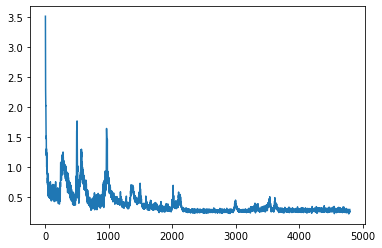

In [11]:
EPOCH = 300
train_res_recon_error = []
train_res_perplexity = []

loss_list = []
val_loss_list = []
ac_list = []
VQ_VAE.train()

for epoch in tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    quantized_merge = torch.empty(0, 1, 64).to(DEVICE)

    for _, (inputs1, inputs2) in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        inputs1 = inputs1.to(DEVICE)
        inputs2 = inputs2.to(DEVICE)
        vq_loss_b, vq_loss_t, recon_b, recon_b2, recon_t, z_b, z_final, quantized_b, perplexity, variance_z_b = VQ_VAE(inputs1, inputs2)
        recon_error_b = F.mse_loss(recon_b, inputs1) / data_variance_1
        recon_error_b2 = F.mse_loss(recon_b2, inputs2) / data_variance_2
        recon_error_t = F.mse_loss(recon_t, z_b) / variance_z_b
        loss = recon_error_b + recon_error_b2 + recon_error_t + vq_loss_b + vq_loss_t
        loss.backward()
        optimizer.step()
        count += 1

        # Append the training loss values for monitoring
        train_res_recon_error.append(recon_error_b.item() + recon_error_t.item())
        train_res_perplexity.append(perplexity.item())

        # Print training statistics
        if count % 5 == 0:  # Adjust this frequency as needed
            print(  f'Epoch [{epoch + 1}/{EPOCH}],'
                    f'Recon Error: {recon_error_b.item() + recon_error_t.item():.4f}, '
                    f'Perplexity: {perplexity.item():.4f}')

# After training, you can print or log other relevant information as needed
print('Training completed.')
plt.plot(train_res_recon_error)

In [12]:
en_lat = []
en_quantized = []
en_labels = []

data_set = Mydatasets(data1 = dat_1, data2 = dat_2)
data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=True)

for i in range(len(dat_1)):
    en_data1 = data_set.dataset[i][0]
    en_data2 = data_set.dataset[i][1]

    _, _, _, _, _, latent_1, latent_2, _, _, _ = VQ_VAE(en_data1.view(1, 1, feature_num_1).float().to(DEVICE), en_data2.view(1, 1, feature_num_2).float().to(DEVICE))
    en_quantized.append(latent_2.cpu().detach().numpy())
    en_lat.append(latent_1.cpu().detach().numpy())
    en_quantized.append(latent_2.cpu().detach().numpy())

encode_out = np.array(en_lat)
encode_out = encode_out.reshape(len(dat_1), -1)
quantized_out = np.array(en_quantized)
quantized_out = quantized_out.reshape(len(dat_1), -1)
print('encode_out:', encode_out.shape)
print('quantized_out:', quantized_out.shape)

latent_Z = encode_out

encode_out: (4445, 64)
quantized_out: (4445, 128)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[0.6676236  0.27846912]
[1.2906325  0.53832924]


/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:198: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors, s=20)


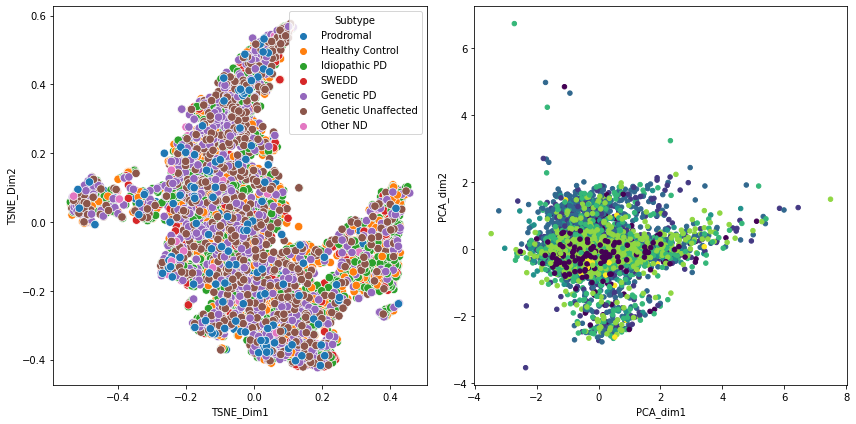

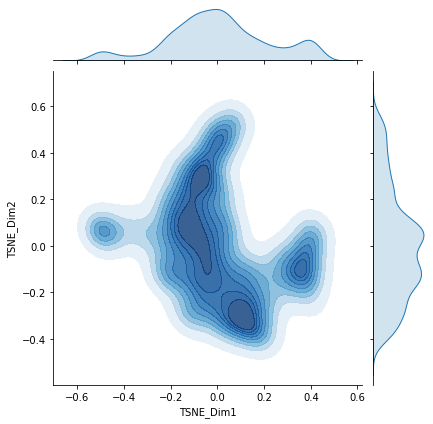

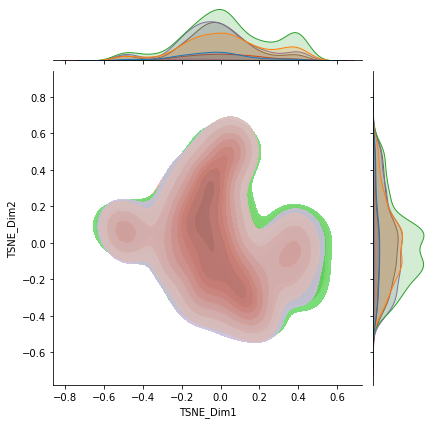

In [14]:
params = {"early_exaggeration":20,
              "learning_rate":500, 
              "perplexity":105, 
              "min_grad_norm":1e-7, 
              "n_iter":10000,
              "n_components":2}
visualisation.plot_clusters(encode_out, label, params)

In [15]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
filenames_mask = filenames_series.str.contains("BL")


# Apply the combined mask to your dataset
filtered_dat = encode_out[filenames_mask]
filtered_clinical_info = clinical_info_series[filenames_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(1521, 64)
(1521,)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[0.6731638 0.2736239]
[1.268124  0.5154601]


/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:198: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors, s=20)


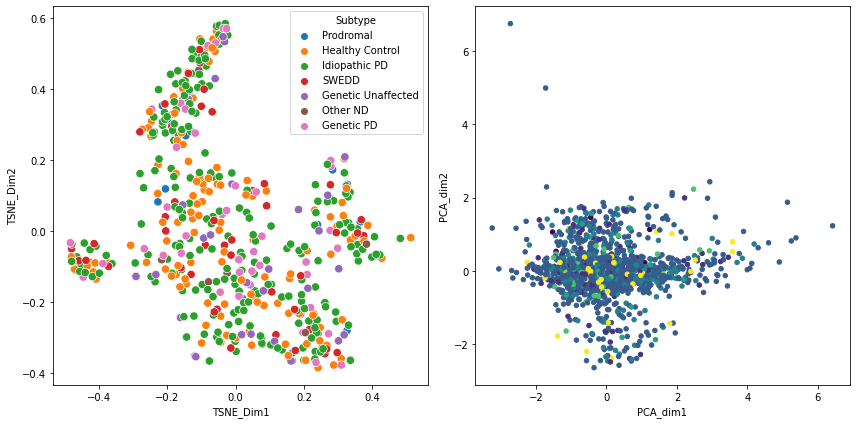

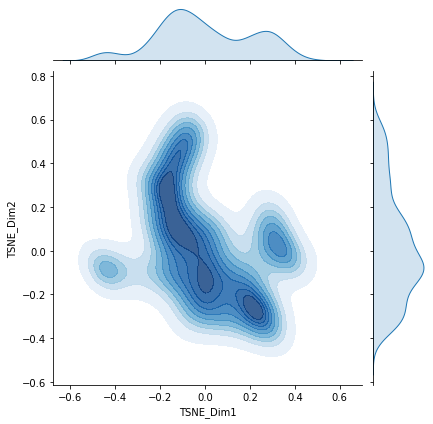

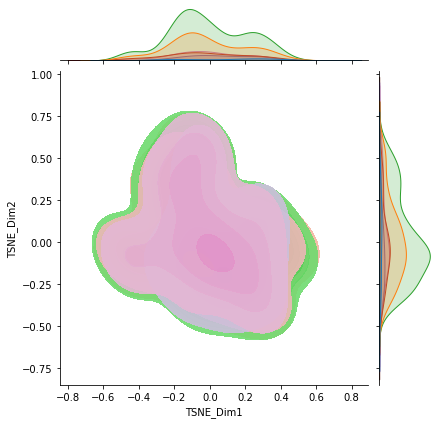

In [16]:
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, params)

In [17]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
#clinical_mask = clinical_info_series == "Genetic PD"
clinical_mask = clinical_info_series == "Idiopathic PD"
filenames_mask = filenames_series.str.contains("BL")

# Combine the masks using logical AND
combined_mask = filenames_mask & clinical_mask

# Apply the combined mask to your dataset

filtered_dat = encode_out[combined_mask]
filtered_clinical_info = clinical_info_series[combined_mask]
filtered_filenames_series = filenames_series[combined_mask] # just to check

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(343, 64)
(343,)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[0.61315894 0.33178926]
[1.1285087  0.61065257]


/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:198: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors, s=20)


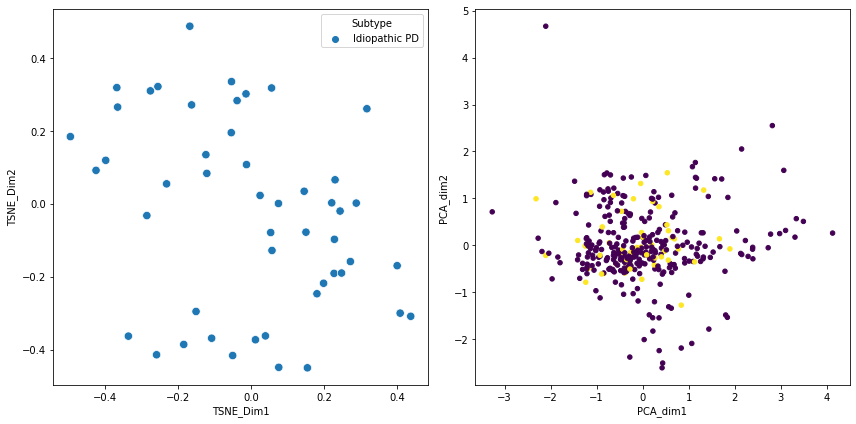

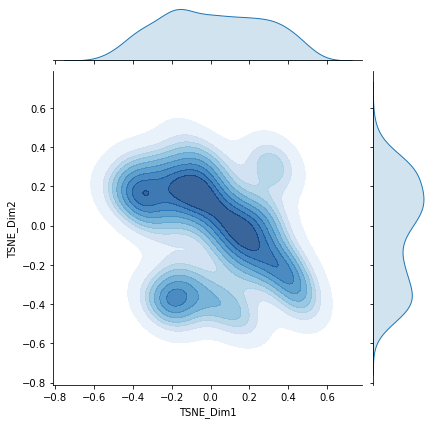

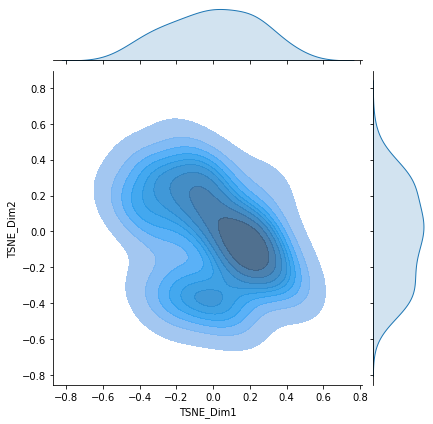

In [18]:
params = {"early_exaggeration":5,
              "learning_rate":100, 
              "perplexity":30, 
              "min_grad_norm":1e-7, 
              "n_iter":10000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, params)

In [19]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
#clinical_mask = clinical_info_series == "Genetic PD"
clinical_mask = clinical_info_series == "Idiopathic PD"
filenames_mask = filenames_series.str.contains("BL")

# Combine the masks using logical AND
combined_mask = clinical_mask

# Apply the combined mask to your dataset

filtered_dat = encode_out[combined_mask]
filtered_clinical_info = clinical_info_series[combined_mask]
filtered_filenames_series = filenames_series[combined_mask] # just to check

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(1400, 64)
(1400,)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[0.62031835 0.3174046 ]
[1.2051762  0.61666477]


/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:198: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors, s=20)


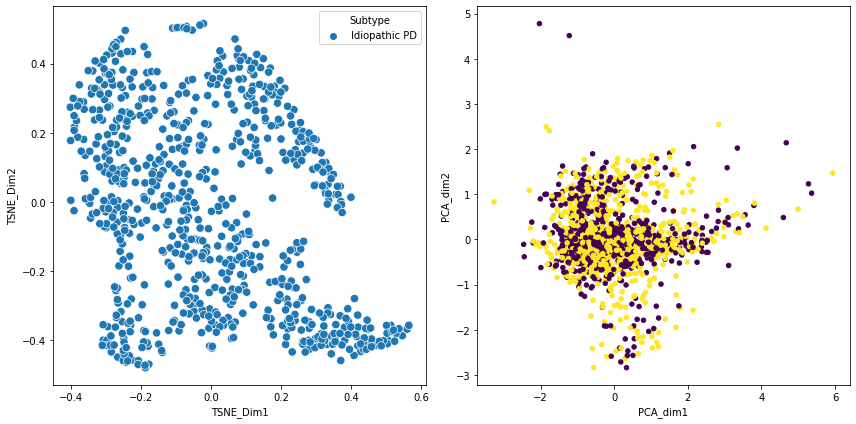

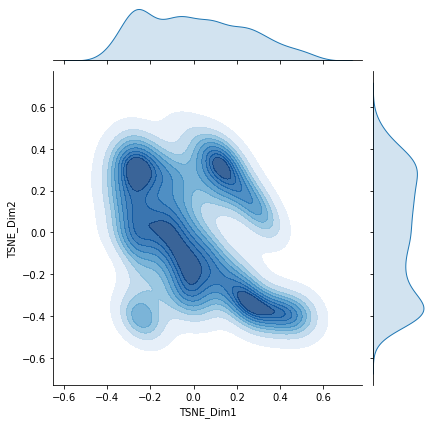

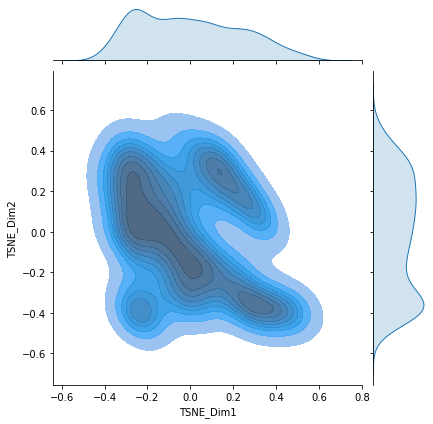

In [20]:
params = {"early_exaggeration":5,
              "learning_rate":100, 
              "perplexity":100, 
              "min_grad_norm":1e-7, 
              "n_iter":10000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, params)

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


TSNE_out: (4445, 2)


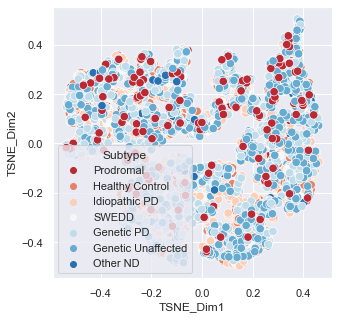

In [26]:
latent_Z = encode_out

tsne = TSNE(early_exaggeration=5,
              learning_rate=500, 
              perplexity=20, 
              min_grad_norm=1e-7, 
              n_iter=5000,
              n_components=2).fit_transform(latent_Z)
x_min, x_max = np.min(tsne, 0), np.max(tsne, 0)
tsne = tsne / (x_max - x_min)
print('TSNE_out:', tsne.shape)

TSNE_result = pd.DataFrame(tsne, columns=['TSNE_Dim1', 'TSNE_Dim2'])
TSNE_result['Subtype'] = label
#tsne of learened feature
plt.figure(figsize=(5,5))
sns.set(style='darkgrid',context='notebook')
sns.scatterplot(data = TSNE_result, x='TSNE_Dim1', y='TSNE_Dim2',hue='Subtype',palette='RdBu',s = 70)
plt.show()

[0.6317198 0.2677317]
[3.443346  1.4593381]
pca_result: (4445, 2)


/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_2252/1427388129.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap,c=colors,s=20)
/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


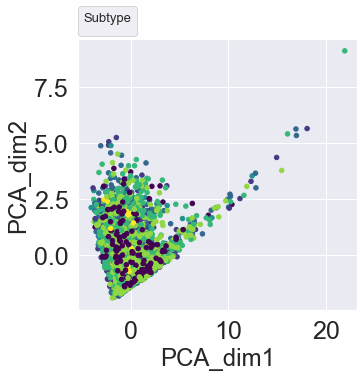

In [22]:
#PCA of learened feature
pca = PCA(n_components=2)
pca.fit(latent_Z)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
pca_result = pca.transform(latent_Z)
print('pca_result:',pca_result.shape)

sns.set(style='darkgrid',context='notebook')
plt.figure(figsize=(5,5)) 

my_cmap = plt.get_cmap('viridis', len(TSNE_result['Subtype'].unique()))
# Map string labels to numeric values
subtype_labels = TSNE_result['Subtype'].unique()
subtype_to_numeric = {subtype: i for i, subtype in enumerate(subtype_labels)}
colors = [my_cmap(subtype_to_numeric[subtype]) for subtype in TSNE_result['Subtype']]


a = plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap,c=colors,s=20)

L = plt.legend(*a.legend_elements(),
           borderaxespad = 1,
           title_fontsize = 13,
           fontsize = 13,
           loc = (0,1.01),
           ncol = 5,
           title="Subtype")
plt.xlabel("PCA_dim1", size=24)  
plt.ylabel("PCA_dim2", size=24)
plt.tick_params(axis='x', which='both', labelsize=25)
plt.tick_params(axis='y', which='both', labelsize=25)

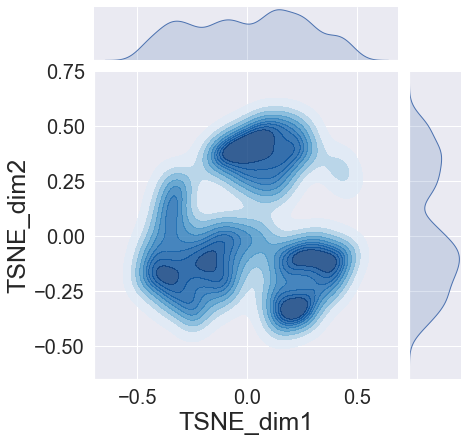

In [23]:
f = sns.jointplot(x=TSNE_result.TSNE_Dim1, y=TSNE_result.TSNE_Dim2, cmap="Blues", fill=True, kind='kde',height=6,
                 marginal_kws={"alpha":.2},thresh=0.05, alpha=.8)
f.ax_joint.set_xlabel("TSNE_dim1",fontsize=25)
f.ax_joint.set_ylabel("TSNE_dim2",fontsize=25)
f.ax_joint.tick_params(labelsize=20)

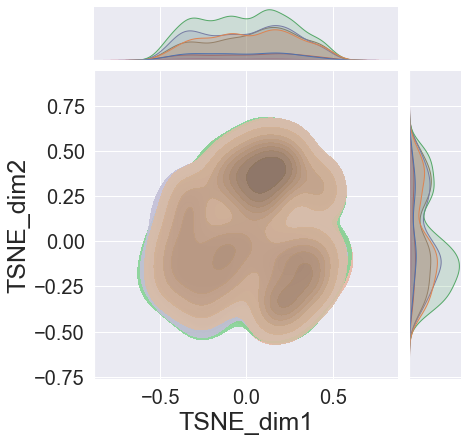

In [24]:
f = sns.jointplot(x=TSNE_result.TSNE_Dim1, y=TSNE_result.TSNE_Dim2, fill=True, kind='kde',hue=TSNE_result.Subtype,height=6,marginal_kws={"alpha":.2},thresh=0.05, alpha=.9)

f.ax_joint.legend_._visible=False
f.ax_joint.set_xlabel("TSNE_dim1",fontsize=25)
f.ax_joint.set_ylabel("TSNE_dim2",fontsize=25)
f.ax_joint.tick_params(labelsize=20)